<a href="https://colab.research.google.com/github/RohanSubramani/Miscellaneous/blob/main/rs4126_RLHW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time
import math
from tqdm import tqdm

from itertools import product
import pandas as pd
import random
from collections import defaultdict
from collections import Counter

# Problem 1

## 1a
$\int_a^b f(x) dx = \int_a^b f(x) \frac{p(x)}{p(x)} dx$ for any p.

$\int_a^b f(x) dx = \int_a^b \frac{f(x)}{p(x)}p(x)  dx$

$\int_a^b f(x) dx = \mathbb{E}_p[\frac{f(x)}{p(x)}]$ for any probability distribution p with support contained in [a,b].

## 1b


In [ ]:
# These functions are named with "2"s at the end because I originally had other versions
def get_good_integral_estimate2(f,p,a,b):
  ti = time.time()
  prev_time = ti
  p = np.vectorize(p)
  true_value, max_error = integrate.quad(f,a,b,limit=int((b-a)*100))
  print(f"Integral true value: {true_value} (max error = {max_error})")
  var = 1 # Just has to be > .0001
  samples = 1

  inverse_cdf = get_inverse_cdf(p,a,b)
  
  while np.sqrt(var) > .01:
  # Could have just checked that the true difference is less than .01, but that's
  # cheating because we aren't supposed to know the true value
      samples *= 2 # Start with 2 samples - one obviously isn't enough, 2 avoids divide by 0 error
      integral, sum_of_squared_residuals = get_integral_estimate2(samples,f,p,a,b,inverse_cdf)
      var = sum_of_squared_residuals/(samples*(samples-1))
      t = time.time()
      if t - prev_time > 30:
        prev_time = t
        diff = abs(integral-true_value)
        print(f"samples = {samples}, integral estimate = {integral}, error of estimate = {diff}, stdev = {np.sqrt(var)}")
      # Variance of sampling distribution of sample means is variance of the base distribution over n
      # Variance of the base distribution is approximately the sum of squares over n-1
  # print("Achieved accuracy")
  samples,integral,var = binary_search2(int(samples/2),samples,f,p,a,b,inverse_cdf)
  print(f"Number of samples: {samples}")
  diff = abs(integral-true_value)
  print(f"Integral estimate: {integral}")
  print(f"Variance of estimate: {var}")
  print(f"Standard deviation of estimate: {np.sqrt(var)}")
  print(f"Error of estimate: {diff}")
  tf = time.time()
  print(f"Time: {tf-ti}")

def get_integral_estimate2(samples,f,p,a,b,inverse_cdf):
  t0 = time.time()
  xs = sample_from_dist(inverse_cdf,a,b,samples)
  t1 = time.time()
  # print(f"samples = {samples}, draw time = {t1-t0}")
  zs = f(xs)/p(xs) # z(x) = f(x)/p(x) for all samples x.
  t2 = time.time()
  integral = np.mean(zs)
  t3 = time.time()
  residuals = zs-integral
  t4 = time.time()
  sum_of_squared_residuals = sum(residuals**2)
  t5 = time.time()
  T0,T1,T2,T3,T4 = t1-t0,t2-t1,t3-t2,t4-t3,t5-t4
  if t5-t0 > 1:
    print(f"Times: {T0,T1,T2,T3,T4}")
  return integral, sum_of_squared_residuals

def get_inverse_cdf(pdf,low,high):
  xs = np.arange(low,high+1e-7,(high-low)/1000)
  ys = [0]
  t0 = time.time()
  prev_x = low
  print("Getting inverse cdf:")
  for i in tqdm(range(1,len(xs))):
    x = xs[i]
    new = integrate.quad(pdf,prev_x,x)[0] # Much faster than starting from the beginning every time
    ys.append(ys[-1]+new)
    prev_x = x
  inverse_cdf = CubicSpline(ys,xs)
  return inverse_cdf

def sample_from_dist(inverse_cdf,low,high,samples):
  randoms_01 = np.random.random(size=samples)
  random_values = inverse_cdf(randoms_01)
  return random_values

def binary_search2(low,high,f,p,a,b,inverse_cdf): # Find smallest sample size with low enough standard deviation
  prev_time = time.time()
  assert low <= high
  while (high-low)/low > .01: # I'm ok with "close enough"
    samples = (int)(low + (high-low)/2) # This is the floor of the midpoint
    integral, sum_of_squared_residuals = get_integral_estimate2(samples,f,p,a,b,inverse_cdf)
    var = sum_of_squared_residuals/(samples*(samples-1))
    if np.sqrt(var) > .01: # Need more samples
      low = samples+1
    else: # Enough samples
      high = samples
    t = time.time()
    if t - prev_time > 30:
      prev_time = t      
      print(f"samples = {samples}, stdev = {np.sqrt(var)}, low = {low}, high = {high}, (high-low)/low = {(high-low)/low}")
  samples = (int)(low + (high-low)/2) # This is the floor of the midpoint
  integral, sum_of_squared_residuals = get_integral_estimate2(samples,f,p,a,b,inverse_cdf)
  var = sum_of_squared_residuals/(samples*(samples-1))
  return samples, integral, var

In [ ]:
f = lambda x : abs((np.sin(np.pi*x))**5 - 2 * ((np.cos(3*((np.cos(x/np.pi))**2)))**3))
p = lambda x: .1 if (0 <= x and x <= 10) else 0
a = 0
b = 10
get_good_integral_estimate2(f,p,a,b)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
Getting inverse cdf:


100%|██████████| 1000/1000 [00:00<00:00, 5094.61it/s]


Number of samples: 669696
Integral estimate: 12.156490962833251
Variance of estimate: 9.943565429666086e-05
Standard deviation of estimate: 0.009971742791340983
Error of estimate: 0.01220516499980917
Time: 4.702976703643799


## 1c

In [ ]:
def plot_f(f,low,high,title=None):
  xs = np.arange(low+1e-7,high,(high-low)/10000)
  ys = [f(x) for x in xs]
  plt.plot(xs,ys)
  plt.xlabel("x")
  plt.ylabel("y")
  if title is not None:
    plt.title(title)
  plt.show()

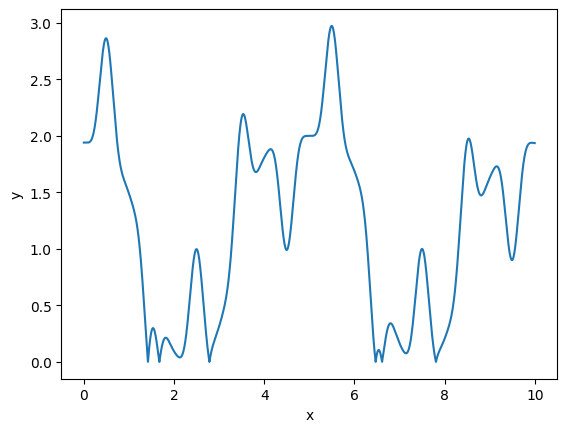

In [ ]:
f = lambda x : abs((np.sin(np.pi*x))**5 - 2 * ((np.cos(3*((np.cos(x/np.pi))**2)))**3))
plot_f(f,0,10)

What would make one probability distribution require fewer samples than another to estimate this integral well by taking the expected value of $\frac{f(x)}{p(x)}$? A low variance for $\frac{f(x)}{p(x)}$. That is, each sample x drawn from p(x) should be highly likely to have $\frac{f(x)}{p(x)}$ close to the mean value of $\frac{f(x)}{p(x)}$. For this to be the case, we want low probabilities associated with low values of f(x) and high probabilities associated with high values of f(x), so the denominator roughly cancels with the numerator. Trying to decompose the graph above into a mix of Gaussians may, just by eyeballing it, look something like this:

weights = [2,2,1.6,1.5,.7,1.5,1.5,1.5] (needs to be normalized)

mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10]

sigmas = [.3,.5,.5,1,.3,.3,.3,.3]

In [ ]:
def truncated_gaussian_mix(weights,mus,sigmas):
  assert abs(sum(weights)-1) < 1e-4
  assert len(weights) == len(mus) and len(weights) == len(sigmas)
  k = len(weights)
  def p(x):
    if x < 0 or x > 10:
      return 0 # Support on 0 to 10
    total = 0
    for i in range(k):
      total += weights[i]*(1/(np.sqrt(2*np.pi*(sigmas[i])**2)))*np.exp((-(x-mus[i])**2)/(2*sigmas[i]**2))
      # Should be equivalent to weights[i]*stats.norm(mus[i], sigmas[i]).pdf(x)
    return total
  integral_of_p, error = integrate.quad(p,0,10,limit=1000)
  def p2(x):
    return p(x)/integral_of_p # Normalize, has integral 1 from 0 to 10 now
  return p2

Exploration and discussion of different mixtures are in the Miscellaneous section below - here I will just report the best findings. The version that had a satisfactorily small variance with the fewest samples was the second one I tried, so I call it "p2" below.


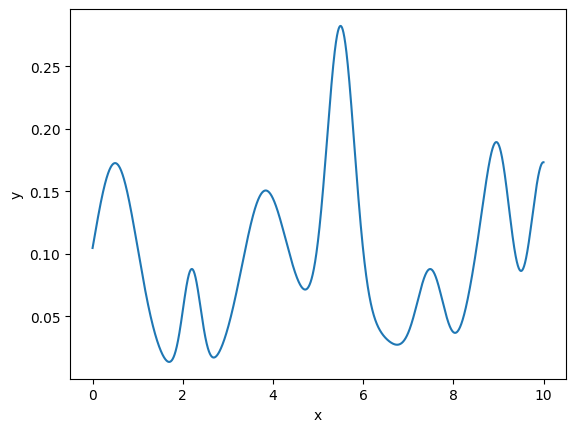

In [ ]:
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5,.5]
weights = [weight/sum(weights) for weight in weights]
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10,2.2]
sigmas = [.3,.5,.5,1,.3,.3,.3,.3,.2]
p2 = truncated_gaussian_mix(weights,mus,sigmas)

plot_f(p2,0,10)

In [ ]:
get_good_integral_estimate2(f,p2,a,b)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
Getting inverse cdf:


100%|██████████| 1000/1000 [00:02<00:00, 488.22it/s]


Times: (0.005085468292236328, 1.0469801425933838, 0.00010776519775390625, 6.0558319091796875e-05, 0.003184795379638672)
Times: (0.007830381393432617, 1.6751635074615479, 0.00014090538024902344, 0.0001049041748046875, 0.005852937698364258)
Times: (0.014780282974243164, 3.3436951637268066, 0.00021147727966308594, 0.0001964569091796875, 0.011612653732299805)
Times: (0.035648345947265625, 8.101500034332275, 0.0003027915954589844, 0.00043487548828125, 0.023391246795654297)
Times: (0.021782875061035156, 5.015071392059326, 0.0002410411834716797, 0.0002963542938232422, 0.017308712005615234)
Times: (0.02571392059326172, 7.398454666137695, 0.00026488304138183594, 0.00037860870361328125, 0.020227670669555664)
Times: (0.029210567474365234, 5.4390904903411865, 0.00026988983154296875, 0.00030732154846191406, 0.01854729652404785)
Times: (0.02477097511291504, 7.045286417007446, 0.00026106834411621094, 0.0003228187561035156, 0.022060155868530273)
Times: (0.025768280029296875, 5.722311735153198, 0.00027

This achieved the same accuracy with only about 225000 samples, where the uniform distribution required about 665000.

##1d

In [ ]:
def beta_mix(weights,alphas,bs):
  assert len(weights) == len(alphas) and len(weights) == len(bs)
  k = len(weights)
  def p(x):
    total = 0
    for i in range(k):
      alpha = alphas[i]
      b = bs[i]
      contribution = weights[i]*stats.beta.pdf(x, alpha, b, scale=10)
      total += contribution
      if math.isnan(contribution) or math.isnan(total):
        print(f"i,total, weights[i], alpha, b, x, contribution = {i,total, weights[i], alpha, b, x, contribution}")
    return total
  integral_of_p, error = integrate.quad(p,0,10,limit=1000)
  print(integral_of_p)
  def p2(x):
    return p(x)/integral_of_p # Normalize, has integral 1 from 0 to 10 now
  return p2

I intended to do a careful exploration and discussion of different mixtures, but this code took an extremely long time to run so I wasn't able to. I only ran it once, with the results as follows. The code actually didn't finish: the variance was nearly down to .0001 by 524288 samples, when I stopped it (since the next iteration would have taken about an hour.

Mean of a beta distribution: $\frac{1}{1 + \frac{\beta}{\alpha}}$

Variance of a beta distribution is larger when α and β are small.

To give myself more control over the beta distributions I add to the mix, I will specify them with a mean and alpha, where alpha gives me control over the variance and the two together uniquely define a value for b. To do this, I need a function to retrieve bs from mus and alphas.

In [ ]:
def get_bs(mus,alphas):
  assert len(mus) == len(alphas)
  bs = []
  for i in range(len(mus)):
    b = alphas[i]*((10-mus[i])/mus[i])
    bs.append(b)
  return bs

weights, sum(weights) = ([1.0], 1.0)
0.9999999999999999


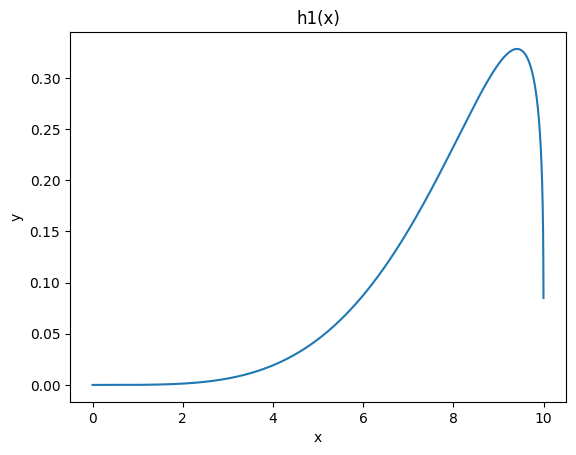

T0,T1=(0.0437626838684082, 1.6226673126220703)


In [ ]:
mus = [8]
alphas = [5]
bs = get_bs(mus,alphas)
weights = [2]*len(mus)
weights = [weight/sum(weights) for weight in weights]
print(f"weights, sum(weights) = {weights,sum(weights)}")
t0 = time.time()
h1 = beta_mix(weights,alphas,bs)
t1 = time.time()
plot_f(h1,0,10,title="h1(x)")
t2 = time.time()
T0,T1 = t1-t0,t2-t1
print(f"T0,T1={T0,T1}")

I didn't actually use the distribution above to compute the integral. I suspect it would have taken even longer than the one below, since it follows the function less well.

weights, sum(weights) = ([0.0900900900900901, 0.11261261261261261, 0.0900900900900901, 0.06756756756756757, 0.03153153153153153, 0.022522522522522525, 0.06756756756756757, 0.06756756756756757, 0.13513513513513514, 0.04504504504504505, 0.04504504504504505, 0.04504504504504505, 0.04504504504504505, 0.04504504504504505, 0.04504504504504505, 0.04504504504504505], 0.9999999999999998)
[1.0, 1.0, 50.0, 100, 30.0, 30.0, 30.0, 30.0, 50.0, 10.0, 10.0, 30.0, 40.0, 10.0, 1.0, 30.0]
0.9999999975781946


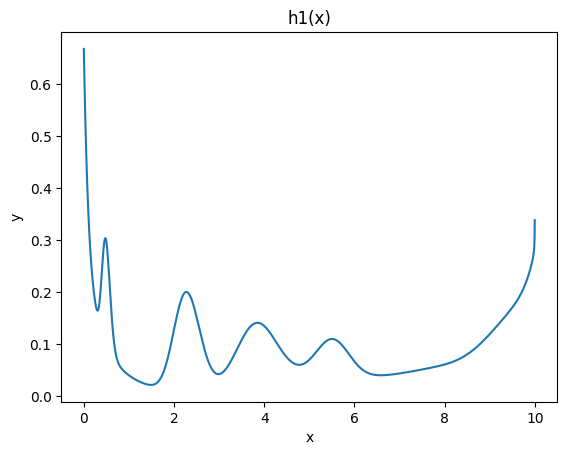

[2.9081513061258617, 37.59783507892244, 0.7354844324043837, 7.4792782012663945, 13.437060039550756, 28.7351280114312, 25.478841586051896, 3.820131002683845, 3.378190640204309, 13.70400649831097]


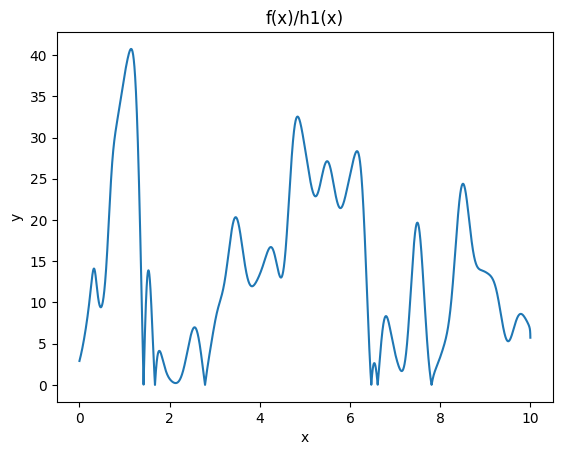

In [ ]:
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5,3,1,1,1,1,1,1,1]
weights = [weight/sum(weights) for weight in weights]
print(f"weights, sum(weights) = {weights,sum(weights)}")
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,9.7,2.3,4.9,6.1,.5,4,8.5,0.1,9.5]
alphas = [.01,.01,.5,1,.3,.3,.3,.3,.5,.1,.1,.3,.4,.1,.01,.3]
alphas = [100*alpha for alpha in alphas]
print(alphas)
bs = get_bs(mus,alphas)

h1 = beta_mix(weights,alphas,bs)
plot_f(h1,0,10,"h1(x)")

d1 = lambda x: f(x)/h1(x)
print([d1(x) for x in range(10)])
plot_f(d1,0,10,title="f(x)/h1(x)")

In [ ]:
get_good_integral_estimate2(f,h1,0,10)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
Getting inverse cdf:


100%|██████████| 1000/1000 [01:49<00:00,  9.11it/s]


samples = 2, stdev = 2.3893839141748074
Times: (0.00018095970153808594, 1.504451036453247, 3.981590270996094e-05, 9.298324584960938e-06, 7.390975952148438e-05)
Times: (0.00045752525329589844, 2.4201560020446777, 4.1961669921875e-05, 9.5367431640625e-06, 0.00016450881958007812)
Times: (0.00031495094299316406, 4.696405410766602, 4.9591064453125e-05, 1.0251998901367188e-05, 0.0002231597900390625)
Times: (0.0005316734313964844, 10.258784770965576, 5.269050598144531e-05, 1.3113021850585938e-05, 0.00042700767517089844)
Times: (0.001840353012084961, 21.008797645568848, 5.459785461425781e-05, 1.52587890625e-05, 0.0008335113525390625)
samples = 8192, stdev = 0.09346460212652022
Times: (0.0028662681579589844, 39.67189383506775, 6.937980651855469e-05, 3.886222839355469e-05, 0.0015358924865722656)
samples = 16384, stdev = 0.0660644848819721
Times: (0.0036661624908447266, 83.06438517570496, 0.00011229515075683594, 6.246566772460938e-05, 0.002986907958984375)
samples = 32768, stdev = 0.0468254161677

KeyboardInterrupt: ignored

The above code shows that the variance is decreasing, but it doesn't show that the integral estimates are actually close to the true value, so I'll run it one more time to show that it is in the right ballpark (and interrupt the run before it takes too long):

In [ ]:
get_good_integral_estimate2(f,h1,0,10)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
Getting inverse cdf:


100%|██████████| 1000/1000 [02:02<00:00,  8.13it/s]


samples = 2, Integral estimate = 14.647243274855498, error of estimate = 2.4785471470224376, stdev = 8.310356480541612
Times: (0.00015783309936523438, 1.1394944190979004, 5.698204040527344e-05, 1.5497207641601562e-05, 9.655952453613281e-05)
Times: (0.00023555755615234375, 2.542299270629883, 5.650520324707031e-05, 1.6450881958007812e-05, 0.00015234947204589844)
Times: (0.0012309551239013672, 4.548607349395752, 4.0531158447265625e-05, 9.775161743164062e-06, 0.0002181529998779297)
Times: (0.00078582763671875, 10.403733730316162, 4.7206878662109375e-05, 9.775161743164062e-06, 0.00042057037353515625)
Times: (0.0009686946868896484, 22.729423761367798, 0.00013017654418945312, 3.504753112792969e-05, 0.0008556842803955078)
samples = 8192, Integral estimate = 12.09667295530862, error of estimate = 0.07202317252444068, stdev = 0.0936457892133375


KeyboardInterrupt: ignored

The outputs of the cell above do demonstrate that this strategy is generally computing the integral correctly.

# Problem 2 - Tic-Tac-Toe

In [ ]:
import numpy as np
from itertools import product
import pandas as pd
import random
from collections import defaultdict
from tqdm import tqdm
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

Using code from the GitHub page linked in the assignment: https://github.com/govindgnair23/RL_Exploration/blob/main/Solving%20Tic%20Tac%20Toe%20with%20RL%20Blog%20-%20vf.ipynb

In [ ]:
class TicTacToe():
    def __init__(self,player = 'X',reward_type ='goal_reward'):
        '''
        player: Role agent should play. If X, agent has the first turn else agent has second turn
        reward_type: 'goal_reward' or 'action_penalty'
        '''
        self.board = np.array(['__']*9).reshape(3,3)
        self.reward_type = reward_type
        self.winning_seqeunce = None #Keep track of winning move made by agent
        self.first_move = None #Keep track of first move made by agent
        if player == 'X':
            self.me ='X'
            self.id = 1
            self.opponent = 'O'
        else:
            self.me = 'O'
            self.id = 2
            self.opponent = 'X'
     
        self.game_over = False #Flag indicating whether game is over
        # Mapping of action representaion in board to action representation in tuple 
        self.b_to_s = {'__':0,'X':1,'O':2} 
        # Mapping of action representaion in tuple to action representation in board
        self.s_to_b = {0:'__',1:'X',2:'O'} 
        
        #Create mapping from 2D position in board to 1D position in tuple
        positions = self.available_positions()
        self.b2_to_s1 = {position:i for (i,position) in enumerate(positions)}
        
        #Create mapping from 1D position in tuple to 2D position in board 
        self.s1_to_b2 = {i:position for (i,position) in enumerate(positions)}
        
        #State the current player is in
        self.starting_state = self.board_to_state()
        
        #Initialize all possible states of the game
        l_o_l = [list(range(3)) for _ in range(9)]
        states = set(product(*l_o_l))
        

        
        #Player X states include states with odd number of blanks and both players have occupied equal number of slots
        #Player O playes after Player X, so player O states include states with even number of blanks and where
        #player X has occupied one more slot than player O
        playerX_states = {state for state in states if (state.count(0)%2 == 1 and state.count(1)==state.count(2))} #
        playerO_states =  {state for state in states if (state.count(0)%2 == 0 and state.count(1)==(state.count(2)+1))}
        
        #States 
        #self.board_full_states = {state for state in states if state.count(0)==0}
        if player == 'X':
            self.my_states = playerX_states
        else:
            self.my_states = playerO_states
          
    
    def reset_board(self):
        "Function to reset game and reset board to starting state"
        self.board = np.array(['__']*9).reshape(3,3)
        self.starting_state = self.board_to_state()
        self.game_over = False
        self.winning_sequence = None
        self.first_move = None
    
    def show_board(self):    
        "Shows board as a pandas dataframe"
        return pd.DataFrame(self.board)
    
    def board_to_state(self):
        "Convert a board to a state in tuple format"
        return tuple([self.b_to_s[x] for x in np.ravel(self.board)])
    
    @staticmethod
    def possible_actions(state):
        "Return possible actions given a state"
        return [i for i,x  in enumerate(state) if x ==0]
    

        
    def is_game_over(self):
        "Function to check if game is over"
        if not np.any(self.board == '__') :
            self.game_over = True
            
        return self.game_over
    
    def available_positions(self):
        "Return available positions on the board"
        x,y = np.where(self.board =='__')
        return[(x,y) for x,y in zip(x,y)]
    
    
    def win(self,player):
        "Check if player won the game and record the winning sequence"
        if np.all(self.board[0,:] == player):
            self.winning_sequence = 'R1'
        elif np.all(self.board[1,:] == player): 
            self.winning_sequence = 'R2'
        elif np.all(self.board[2,:] == player):
            self.winning_sequence = 'R3'
        elif np.all(self.board[:,0] == player):
            self.winning_sequence = 'C1'
        elif np.all(self.board[:,1] == player):
            self.winning_sequence = 'C2'
        elif np.all(self.board[:,2] == player):
            self.winning_sequence = 'C3'
        elif np.all(self.board.diagonal()==player):
            self.winning_sequence = 'D1'
        elif  np.all(np.fliplr(self.board).diagonal()==player):
            self.winning_sequence = 'D2'
        else:
            return False
        
        return True
    
    
    def my_move(self,position):
        "Fills out the board in the given position with the action of the agent"
        
        # try:
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        # except TypeError:
        #   print(position)
        #   raise TypeError
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.me
        
        I_win = self.win(self.me)
        opponent_win = self.win(self.opponent)
        
        if self.reward_type == 'goal_reward':
            if I_win:
                self.game_over = True
                return 1
            
            elif opponent_win:
                self.game_over = True
                return -1
            
            else:
                return 0
            
        elif self.reward_type == 'action_penalty':
            if I_win:
                self.game_over = True
                return 0
            
            elif opponent_win:
                self.game_over = True
                return -10
            
            else:
                return -1
    
    def opponent_move(self,position):
        "Fills out the board in the given position with the action of the opponent"
        assert position[0] >= 0 and position[0] <= 2 and position[1] >= 0 and position[1] <= 2 , "incorrect position"
        assert self.board[position] == "__" , "position already filled"
        assert np.any(self.board == '__') , "Board is complete"
        assert self.win(self.me) == False and self.win(self.opponent)== False , " Game has already been won"
        self.board[position] = self.opponent
            

#     def get_action(self,next_state):
#         " return action that will take agent to the specified next state"
#         current_state = self.board_to_state()
#         return [i for (i,j) in enumerate(current_state) if current_state[i]==0 and next_state[i]==self.id][0]
        
        
    
    def pick_best_action(self,Q,action_type,eps=None):
        '''Given a Q function return optimal action
        If action_type is 'greedy' return best action with ties broken randomly else return epsilon greedy action
        '''
        #Get possible actions
        current_state = self.board_to_state()
        actions =  self.possible_actions(current_state)

        if action_type == 'defensive':
            action = self.defensive_move(current_state,actions)
            return self.s1_to_b2[action]
        
        if action_type == 'human':
          action = -1
          while action < 0:
            action = int(input(f"Enter the position you want (a number in {actions}, labeled row-by-row): "))
            if action < 0 or action > 8:
              action = -1
          return self.s1_to_b2[action]
        
        best_action = []
        best_action_value = -np.Inf
        
        if action_type == 'greedy' or eps < 1.0:
          for action in actions:
              Q_s_a = Q[current_state][action]
              if Q_s_a == best_action_value:
                  best_action.append(action)
              elif Q_s_a > best_action_value:
                  best_action = [action]
                  best_action_value = Q_s_a
          best_action = random.choice(best_action)

          if action_type == 'greedy':
              return self.s1_to_b2[best_action]

        assert eps != None , "Include epsilon parameter"
        n_actions =len(actions) #No of legal actions 
        p = np.full(n_actions,eps/n_actions)
        if eps < 1.0:
          #Get index of best action
          best_action_i = actions.index(best_action)
          p[best_action_i]+= 1 - eps
        return self.s1_to_b2[np.random.choice(actions,p=p)]
    
    def defensive_move(self,board_state,available_actions):
        # Check if the opponent has any potential winning moves
        for i in range(len(board_state)):
            if board_state[i] == 0:
                temp_state = list(board_state)
                temp_state[i] = 3 - self.id # Simulate other player taking this action
                if self.is_winning_move(temp_state, 3-self.id):
                    return i
        
        # If there are no winning moves to block, choose a random available move
        return np.random.choice(available_actions)

    def is_winning_move(self,board_state, player):
        # Check horizontal lines
        for i in range(0, 9, 3):
            if board_state[i:i+3] == [player]*3:
                return True
        
        # Check vertical lines
        for i in range(3):
            if board_state[i::3] == [player]*3:
                return True
        
        # Check diagonal lines
        if board_state[0] == player and board_state[4] == player and board_state[8] == player:
            return True
        if board_state[2] == player and board_state[4] == player and board_state[6] == player:
            return True
        
        return False

In [ ]:
def play_games(n_games,Q_X,Q_O,X_strategy = 'eps_greedy',O_strategy='eps_greedy',eps_X=0.05,eps_O=0.05,seed=1):
    """ Function to play tic tac toe specified no of times, and return summary of win statistics
        n_games: No of times to play the game
        Q_X: Q function for player X that gives X's policy
        Q_O: Q function for player O that gives O's policy
        X_strategy: eps_greedy or greedy
        O_strategy: eps_greedy or greedyj
        
    """
    np.random.seed(seed)
    #Dictionary for holding results of simulation
    win_stats = defaultdict(int)
    #List to  hold winning sequences of the winning player
    winning_sequences_X = []
    winning_sequences_O = []
    
    
    #List of final boards
    final_boards = []
   
    t_board_X = TicTacToe(player = 'X',reward_type ='action_penalty')
    t_board_O = TicTacToe(player = 'O',reward_type ='action_penalty')
    X_first_actions = [] #List to record first actions of player X
    O_first_actions = [] #List to record first actions of player O
    winning_X_first_actions = [] #List to record first actions that resulted in wins
    winning_O_first_actions = [] #List to record first actions that resulted in wins

    human_player = X_strategy == 'human' or O_strategy == 'human'
    
    for i in tqdm(range(n_games),position = 0 ,leave=True):
         #Boards for players X and O
        first_action_flag = True
        while True:
            #X plays first
            if first_action_flag == True and human_player:
                print(t_board_X.show_board())
            x_action = t_board_X.pick_best_action(Q_X,action_type=X_strategy,eps=eps_X)
            if first_action_flag == True:
                X_first_actions.append(x_action)
            t_board_X.my_move(x_action) #make move on X's board
            if human_player:
                print(t_board_X.show_board())
            t_board_O.opponent_move(x_action) #make same move on O's board
            if t_board_X.is_game_over(): #need to end game here if X makes the winning move
                break
            #O plays second
            o_action = t_board_O.pick_best_action(Q_O,action_type=O_strategy,eps=eps_O)
            if first_action_flag == True:
                O_first_actions.append(o_action)
                first_action_flag = False
            t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board
            if human_player:
                print(t_board_X.show_board())
            if t_board_O.is_game_over(): #need to end game here if O makes the winnng move
                break
        #Check who won game or if game was drawn
        if t_board_X.win('X'):
            win_stats['X_win'] += 1
            winning_sequences_X.append(t_board_X.winning_sequence)
            winning_X_first_actions.append(X_first_actions[-1])
            
        elif t_board_X.win('O'):
            win_stats['O_win'] += 1
            winning_sequences_O.append(t_board_O.winning_sequence)
            winning_O_first_actions.append(O_first_actions[-1])
        else:
            win_stats['Draw'] += 1
        final_boards.append(t_board_X.show_board())
        t_board_X.reset_board()
        t_board_O.reset_board()
    
    return win_stats,final_boards,winning_sequences_X,winning_sequences_O,X_first_actions, \
            O_first_actions,winning_X_first_actions,winning_O_first_actions
            
    
# Below we define a function to run simulations of the game and return essential statistics.

def get_win_statistics(Q_X,Q_O,sets = 5, games_in_set = 100,X_strategy = 'eps_greedy',O_strategy='eps_greedy', \
                       eps_X=1.0,eps_O=1.0):
    
    """
    Function to get winning statistics by pitting competing strategies. 
    Q_X: Q table representing the strategy of X
    Q_O: Q Table representing the strategy of O
    sets: No of sets to be played
    games_in_set: No of games in each set
    X_strategy: greedy or epsilon greedy
    O_strategy: greedy or epsilon greedy
    eps_X and eps_O: epsilon in case of epsilon greedy strategy, set to 1 for random strategy
    """
    win_stats_list = []
    winning_sequences_X_list = []
    winning_sequences_O_list = []
    X_first_actions_list = []
    O_first_actions_list = []
    winning_X_first_actions_list = []
    winning_O_first_actions_list = []

    for i in range(sets):
        win_stats, _ ,winning_sequences_X,winning_sequences_O,X_first_actions,O_first_actions, \
        winning_X_first_actions,winning_O_first_actions=  play_games(n_games=games_in_set,\
                            Q_X=Q_X,Q_O=Q_O,X_strategy = X_strategy,O_strategy=O_strategy,eps_X=eps_X,eps_O=eps_O,seed=i)
        win_stats_list.append(win_stats)
        winning_sequences_X_list.append(winning_sequences_X)
        winning_sequences_O_list.append(winning_sequences_O)
        X_first_actions_list.append(X_first_actions)
        O_first_actions_list.append(O_first_actions)
        winning_X_first_actions_list.append(winning_X_first_actions)
        winning_O_first_actions_list.append(winning_O_first_actions)
        
        #Unwrap these lists
    flatten =  lambda l:[item for sublist in l for item in sublist] 
    winning_sequences_X_list = flatten(winning_sequences_X_list)
    winning_sequences_O_list = flatten(winning_sequences_O_list)
    X_first_actions_list = flatten(X_first_actions_list)
    O_first_actions_list = flatten(O_first_actions_list)
    winning_X_first_actions_list = flatten(winning_X_first_actions_list)
    winning_O_first_actions_list = flatten(winning_O_first_actions_list)
    
    win_stats_df  = pd.DataFrame(win_stats_list)
#     stats = win_stats_df.describe()
#     lb = stats.loc['mean'] - 2 * stats.loc['std'] 
#     ub = stats.loc['mean'] + 2 * stats.loc['std']
#     results_df = pd.concat([lb,ub],axis=1)
#     results_df.columns= ['mu - 2 sd', 'mu + 2 sd']
    
    return (win_stats_df),(winning_sequences_X_list,winning_sequences_O_list),\
    (X_first_actions_list,winning_X_first_actions_list),(O_first_actions_list, winning_O_first_actions_list)
            
# Another set of utility functions to process win statistics

#Mapping from 2D position to 1D position
map_2d_1d = {(0, 0): 0, (0, 1): 1,(0, 2): 2, (1, 0): 3, (1, 1): 4,(1, 2): 5,(2, 0): 6,(2, 1): 7,(2, 2): 8}

def get_win_rate(first_actions_list,winning_first_actions_list):
    "Get win rate in appropriate format from experiment results"
    first_actions = dict(Counter(first_actions_list))
    winning_first_actions = dict(Counter(winning_first_actions_list))
    win_rate = np.array([winning_first_actions.get(key,0)/first_actions.get(key,1) \
                         for key in sorted(map_2d_1d.keys())]).reshape(3,3)
    
    return win_rate


def get_win_seqs(winning_sequences_list):
    "Get winning sequence stats in appropriate format from experiment results"
    temp_dict = dict(Counter(winning_sequences_list))
    win_seq_df = pd.DataFrame({'winning_sequence':list(temp_dict.keys()),'N':list(temp_dict.values())})
    
    return win_seq_df
    
        
# And a function to visualize the statistics

def plot_results(win_statistics):
    "Function to visualize results of experiments"
    sns.set(font_scale=5)
    final_results,winning_sequences,first_actions_X,first_actions_O = win_statistics
    win_stats_df_long = pd.melt(final_results,var_name='Result',value_name='N')
    plt.subplots_adjust(hspace = 2)
    fig, axs = plt.subplots(nrows = 2, ncols=3,figsize=(100,40))
    bplot = sns.boxplot(x="Result",y="N",data=win_stats_df_long, \
                ax=axs[0,0]).set_title("Distribution of Wins,Losses and Ties")

    #Plot aggregate results
    final_results_agg = pd.DataFrame(final_results.apply(sum,0),columns=["N"])
    final_results_agg.reset_index(level=0,inplace=True)

    splot = sns.barplot(x="index",y="N",data=final_results_agg,ax=axs[0,1])
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, -12), 
                       textcoords = 'offset points')
    splot.set_title('Total No of Wins,Losses and Ties')

    win_rate_X = get_win_rate(*first_actions_X)
    win_rate_O = get_win_rate(*first_actions_O)

    _ = sns.heatmap(win_rate_X,annot=True,ax=axs[0,2]).set_title("Player X: % of wins for first move")
    _ = sns.heatmap(win_rate_O,annot=True,ax=axs[1,0]).set_title("Player O: % of wins for first move")

    #Gets stats of winning sequences for player X and player O
    win_seq_X = get_win_seqs(winning_sequences[0])
    win_seq_O = get_win_seqs(winning_sequences[1])

    _ = sns.barplot(x='winning_sequence',y='N',data=win_seq_X,
           order=['R1','R2','R3','C1','C2','C3','D1','D2'],ax=axs[1,1]).set_title("Player X: winning sequences")

    _ = sns.barplot(x='winning_sequence',y='N',data=win_seq_O,
           order=['R1','R2','R3','C1','C2','C3','D1','D2'],ax=axs[1,2]).set_title("Player O: winning sequences")

    plt.show()
    #Reset font size for future plots
   
    
# Another utility function we need is one to randomly intialize the Q table which encapsulates a policy by quantifing the value of each state and action.

def initialize_Q(S,seed = 1):
    "Given a state assign random values to each possible action"
    np.random.seed(seed)
    Q = {}
    for state in S:
        Q[state]= {}
        for i,x  in enumerate(state): # Loop through action
            if x == 0:
                Q[state][i] = np.random.rand()
    
    return Q

def initialize_train_counts(S):
    "Assign count 0 to all state-action pairs at the start"
    train_counts = {}
    for state in S:
        train_counts[state]= {}
        for i,x  in enumerate(state): # Loop through action
            train_counts[state][i] = 0
    
    return train_counts

def moving_average(x, w):
    "Function to calculate moving average of rewards"
    return np.convolve(x, np.ones(w), 'valid') / w

def qlearning_train(n_games=1000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False,is_random=True,t_board_X=None,t_board_O=None,**kwargs):
    """
    Function to train a player in a game of tic-tac-toe
    Arguments:
        n_games: Number of games on which to train
        alpha: Learning rate
        gamme: discount factor
        train_X: Flag indicating whether player X should be trained
        train_O: Flag inficating whether player O should be trained
        is_random: should actions of untrained agent be random or deterministic according to Q table
    
    """
     
    
    # If Q is not provided, randomize intially, if provided, it will be used to select actions greedily
    if "Q_X" in kwargs:
        action_type_X = "greedy"
        assert train_X == False ,"Train flag should be set to False if Q table is being provided"
        Q_X = kwargs["Q_X"]
    else:
        States_X = t_board_X.my_states # Will raise an error if no t_board passed in
        Q_X = initialize_Q(States_X)
        
    if "Q_O" in kwargs:
        action_type_O = "greedy"
        assert train_O == False ,"Train flag should be set to False if Q table is being provided"
        Q_O = kwargs["Q_O"]
    else:
        States_O = t_board_O.my_states # Will raise an error if no t_board passed in
        Q_O = initialize_Q(States_O)
    
    
    #Set epsilon value conditional on whether we are training X or O
    eps_ = lambda flag,i: 0.05*0.99**i if flag else 1.0
    
    
    #Lists to keep track of rewards earned by both players during training
    
    rewards_X = []
    rewards_O = []
    
    
    if train_X:
        X_action_type = 'eps_greedy'
    else:
        X_action_type = 'greedy'
        if is_random:
            X_action_type = 'eps_greedy'
        
            
    
    if train_O:
        O_action_type = 'eps_greedy'
    else:
        O_action_type = 'greedy'
        if is_random:
            O_action_type = 'eps_greedy'
            
    for i in tqdm(range(n_games),position=0,leave=True):
        
        eps = 0.05*0.99**i
        t_board_X.reset_board()
        t_board_O.reset_board()

        #X lands on empty board
        S_X = t_board_X.board_to_state()
        
        #X plays first
        eps = eps_(train_X,i)
        
            
        x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
        x_action1d = t_board_X.b2_to_s1[x_action]
        
        R_X = t_board_X.my_move(x_action) # make move on X's board
        t_board_O.opponent_move(x_action) # make same move on O's board

        while not (t_board_X.is_game_over() or t_board_O.is_game_over()):
            S_O = t_board_O.board_to_state()
            
            #O plays second
            eps = eps_(train_O,i)
            
            
            o_action = t_board_O.pick_best_action(Q_O,action_type=O_action_type,eps=eps)
            o_action1d = t_board_O.b2_to_s1[o_action]
            R_O = t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board
            if  t_board_O.is_game_over(): 
                #need to end game here if O makes the winnng move and add a reward 
                if train_O:
                    Q_O[S_O][o_action1d] += alpha*(R_O + 0 - Q_O[S_O][o_action1d]) # 0 given value of terminal state is 0
                
                if train_X:
                #Need to penalize X's previous action if game is over
                    Q_X[S_X][x_action1d] += alpha*(-R_O + 0 - Q_X[S_X][x_action1d]) 
                
                rewards_O.append(R_O)
                rewards_X.append(-R_O)
                break
            
            S_X_new = t_board_X.board_to_state() #Get new state
            #Calculate max_a Q_X(S',a)
            if train_X:
                x_action_ = t_board_X.pick_best_action(Q_X,action_type = 'greedy',eps=0.05) #best action from S_new
                x_action_1d = t_board_X.b2_to_s1[x_action_]
                Q_X[S_X][x_action1d]+= alpha*(R_X + gamma*Q_X[S_X_new][x_action_1d] - Q_X[S_X][x_action1d])
        
            S_X = S_X_new
    
            

            # X plays next
            eps = eps_(train_X,i)
            x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
            x_action1d = t_board_X.b2_to_s1[x_action]
            R_X = t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board

            if t_board_X.is_game_over(): 
                if train_O:
                    #need to end game here if X makes the winning move and make sure O's action is penalized
                    Q_O[S_O][o_action1d] += alpha*(-R_X + 0 - Q_O[S_O][o_action1d]) #0 given value of terminal state is 0
                
                if train_X:
                    #need to end game here if X makes the winning move and make sure reward is added to V
                    Q_X[S_X][x_action1d] += alpha*(R_X + 0 - Q_X[S_X][x_action1d]) #0 given value of terminal state is 0
                
                rewards_X.append(R_X)
                rewards_O.append(-R_X)
                break   


            S_O_new = t_board_O.board_to_state() #Get new state
            #Calculate max_a Q_O(S',a)
            if train_O:
                o_action_ = t_board_O.pick_best_action(Q_O,action_type = 'greedy',eps=0.05) #best action from S_new
                o_action_1d = t_board_O.b2_to_s1[o_action_]
                Q_O[S_O][o_action1d]+= alpha*(R_O + gamma*Q_O[S_O_new][o_action_1d] - Q_O[S_O][o_action1d])

            S_O = S_O_new
            
    if train_X:
        rewards = rewards_X
    elif train_O:
        rewards = rewards_O
        
    sns.set(font_scale=1)
    m_avg = moving_average(rewards,w=200)
    sns.lineplot(x=range(len(m_avg)),y=m_avg).set_title('Learning Curve')
    plt.show()
        
    return Q_X,Q_O,rewards_X,rewards_O

##2a
Random vs Defensive Policies. First I do 5000 games where the defensive policy plays first, then I do 5000 where the random policy goes first.

In [ ]:
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')

# We will first enumerate the states for both sets of players.

States_X = t_board_X.my_states
States_O = t_board_O.my_states

# Create a Q-table for both.

Q_X = initialize_Q(States_X)
Q_O = initialize_Q(States_O)

# Let us see what the results look like over 1000 games.

#final_results,winning_sequences,first_actions_X,first_actions_O 
win_statistics= get_win_statistics(Q_X, Q_O,sets = 10,\
games_in_set = 500,X_strategy = 'defensive',O_strategy='eps_greedy',eps_X=1.0,eps_O=1.0) 
# eps = 1.0 is random policy, eps doesn't affect defensive

100%|██████████| 500/500 [00:01<00:00, 299.86it/s]


<Figure size 640x480 with 0 Axes>

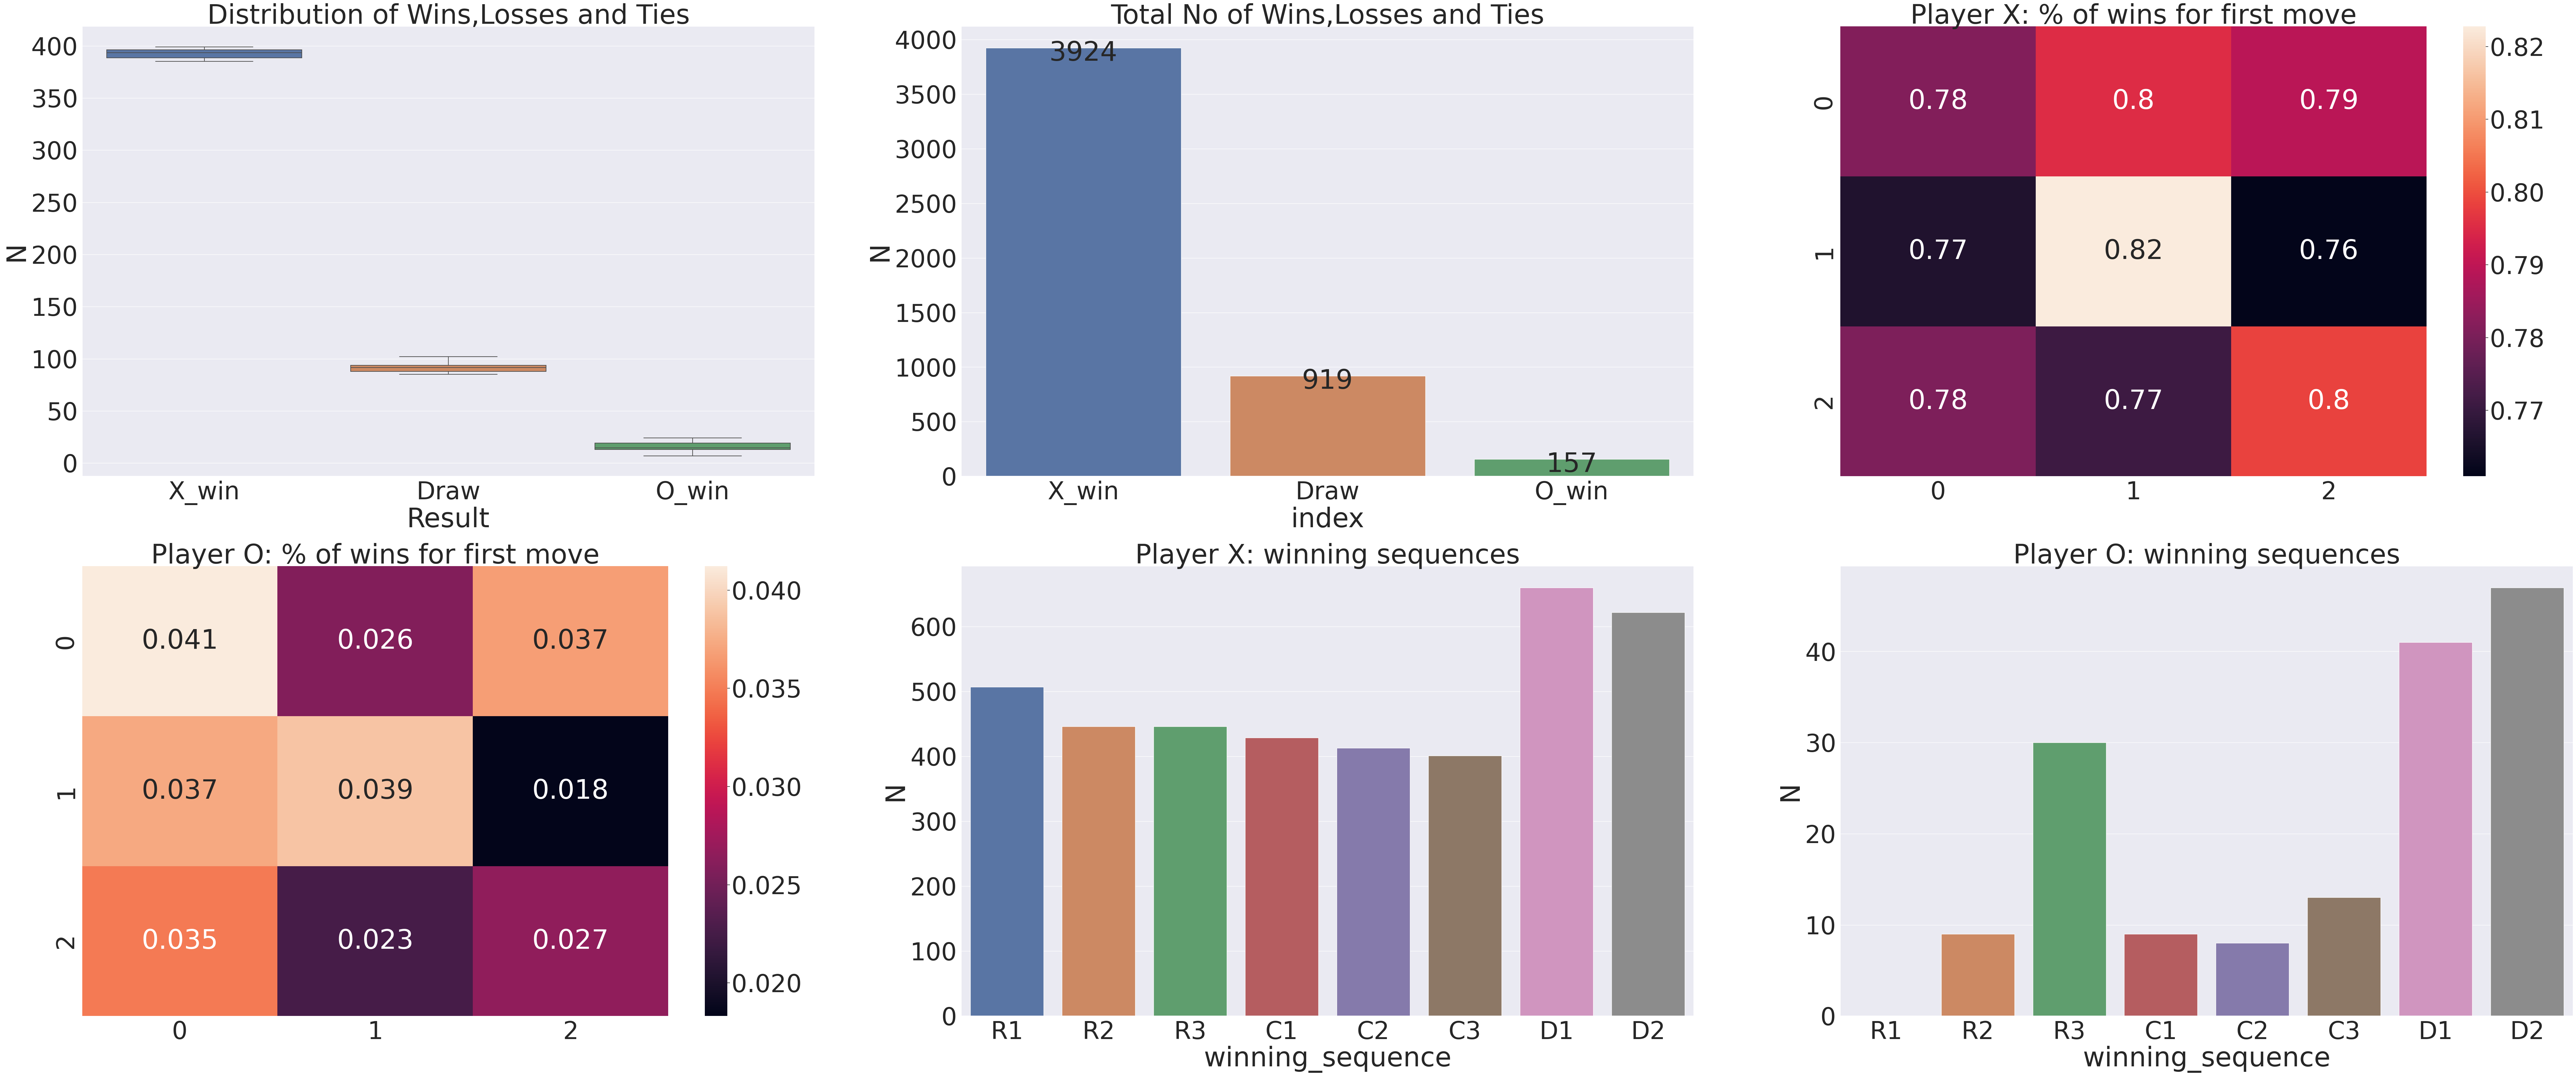

In [ ]:
plot_results(win_statistics)

The plots above show the results when the defensive policy (here X) plays first. 

In [ ]:
win_statistics= get_win_statistics(Q_X, Q_O,sets = 10,\
games_in_set = 500,X_strategy = 'eps_greedy',O_strategy='defensive',eps_X=1.0,eps_O=1.0) 
# eps = 1.0 is random policy, eps doesn't affect defensive

100%|██████████| 500/500 [00:01<00:00, 267.81it/s]


<Figure size 640x480 with 0 Axes>

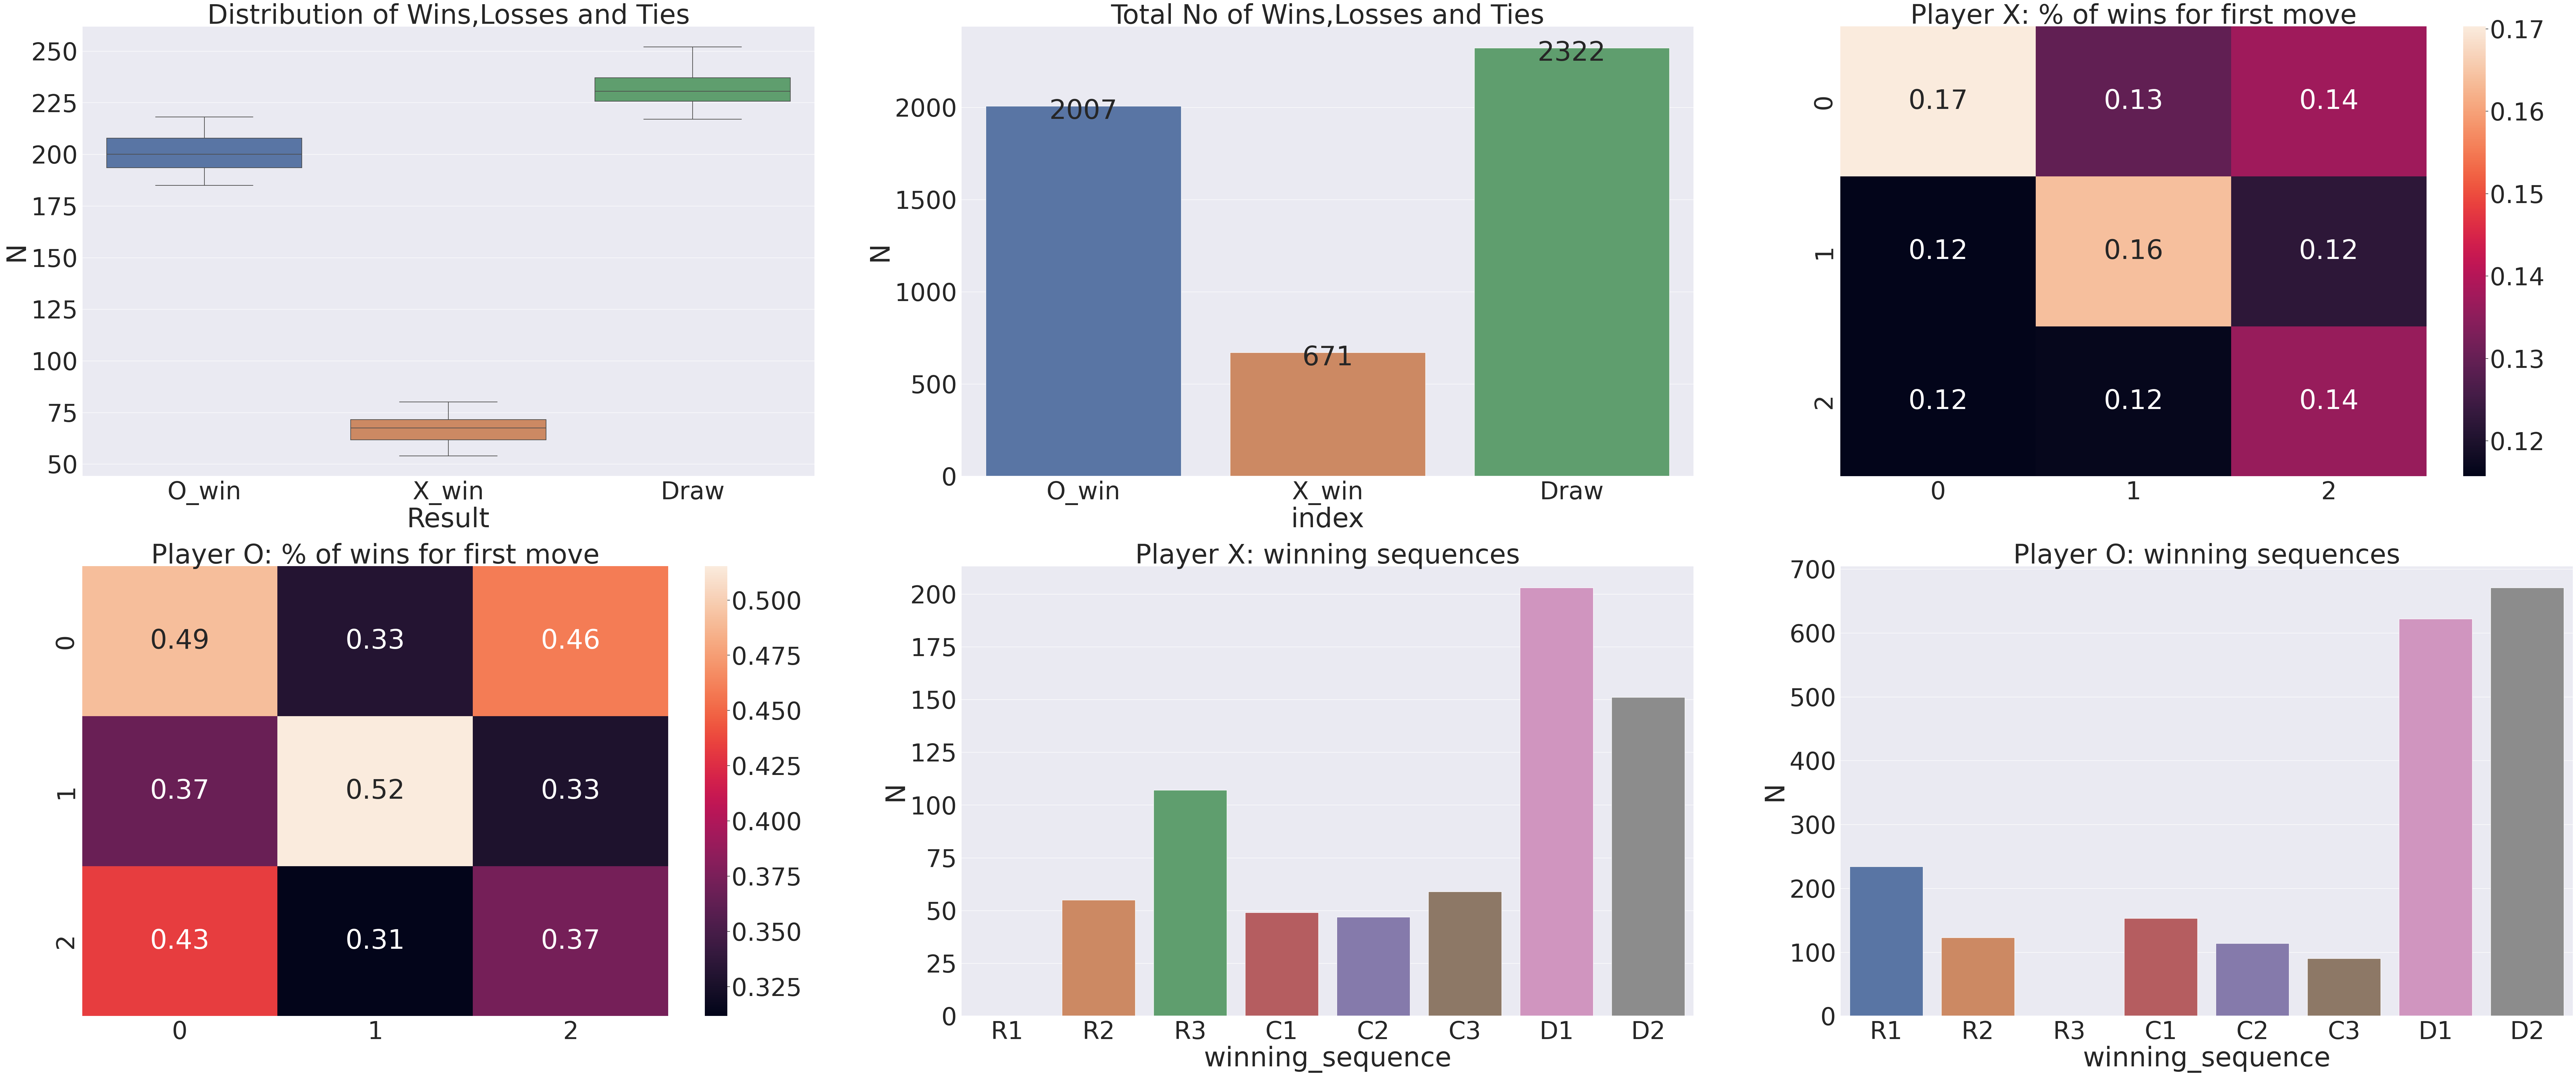

In [ ]:
plot_results(win_statistics)

The plots above show the results when the defensive policy (here O) plays second.

An example with a human player:

In [ ]:
win_statistics= get_win_statistics(Q_X, Q_O,sets = 1,\
games_in_set = 1,X_strategy = 'human',O_strategy='defensive',eps_X=1.0,eps_O=1.0) 
# eps doesn't affect either

  0%|          | 0/1 [00:00<?, ?it/s]

    0   1   2
0  __  __  __
1  __  __  __
2  __  __  __
Enter the position you want (a number in [0, 1, 2, 3, 4, 5, 6, 7, 8], labeled row-by-row): 4
    0   1   2
0  __  __  __
1  __   X  __
2  __  __  __
    0   1   2
0  __  __  __
1  __   X   O
2  __  __  __
Enter the position you want (a number in [0, 1, 2, 3, 6, 7, 8], labeled row-by-row): 2
    0   1   2
0  __  __   X
1  __   X   O
2  __  __  __
    0   1   2
0  __  __   X
1  __   X   O
2   O  __  __
Enter the position you want (a number in [0, 1, 3, 7, 8], labeled row-by-row): 0
    0   1   2
0   X  __   X
1  __   X   O
2   O  __  __
    0   1   2
0   X   O   X
1  __   X   O
2   O  __  __
Enter the position you want (a number in [3, 7, 8], labeled row-by-row): 8


100%|██████████| 1/1 [00:28<00:00, 28.06s/it]

    0   1  2
0   X   O  X
1  __   X  O
2   O  __  X


An example with both players human:

In [ ]:
win_statistics= get_win_statistics(Q_X, Q_O,sets = 1,\
games_in_set = 1,X_strategy = 'human',O_strategy='human',eps_X=1.0,eps_O=1.0) 
# eps doesn't affect either

  0%|          | 0/1 [00:00<?, ?it/s]

    0   1   2
0  __  __  __
1  __  __  __
2  __  __  __
Enter the position you want (a number in [0, 1, 2, 3, 4, 5, 6, 7, 8], labeled row-by-row): 0
    0   1   2
0   X  __  __
1  __  __  __
2  __  __  __
Enter the position you want (a number in [1, 2, 3, 4, 5, 6, 7, 8], labeled row-by-row): 4
    0   1   2
0   X  __  __
1  __   O  __
2  __  __  __
Enter the position you want (a number in [1, 2, 3, 5, 6, 7, 8], labeled row-by-row): 2
    0   1   2
0   X  __   X
1  __   O  __
2  __  __  __
Enter the position you want (a number in [1, 3, 5, 6, 7, 8], labeled row-by-row): 1
    0   1   2
0   X   O   X
1  __   O  __
2  __  __  __
Enter the position you want (a number in [3, 5, 6, 7, 8], labeled row-by-row): 7
    0  1   2
0   X  O   X
1  __  O  __
2  __  X  __
Enter the position you want (a number in [3, 5, 6, 8], labeled row-by-row): 3
    0  1   2
0   X  O   X
1   O  O  __
2  __  X  __
Enter the position you want (a number in [5, 6, 8], labeled row-by-row): 5
    0  1   2
0   X  O   X
1 

100%|██████████| 1/1 [00:52<00:00, 52.65s/it]

   0  1  2
0  X  O  X
1  O  O  X
2  X  X  O


##2b
Monte Carlo First Vist ϵ-greedy. First visit part is actually irrelevant here, since you never visit a board state multiple times in a game of Tic Tac Toe. 

In [ ]:
def mc_fv_eps_greedy_train(n_games=1000, gamma = 1.0,train_X=True,train_O=False,is_random=True,is_defensive=False,
                           t_board_X=None,t_board_O=None,**kwargs):
    """
    Function to train a player in a game of tic-tac-toe
    Arguments:
        n_games: Number of games on which to train
        gamma: discount factor
        train_X: Flag indicating whether player X should be trained
        train_O: Flag inficating whether player O should be trained
        is_random: should actions of untrained agent be random
        is_defensive: should actions of untrained agent be defensive (deterministic according to Q table otherwise)    
    """
     
    
    # If Q is not provided, randomize intially, if provided, it will be used to select actions greedily
    if "Q_X" in kwargs:
        action_type_X = "greedy"
        assert train_X == False ,"Train flag should be set to False if Q table is being provided"
        Q_X = kwargs["Q_X"]
    else:
        States_X = t_board_X.my_states # Will raise an error if no t_board passed in
        Q_X = initialize_Q(States_X)
        
    if "Q_O" in kwargs:
        action_type_O = "greedy"
        assert train_O == False ,"Train flag should be set to False if Q table is being provided"
        Q_O = kwargs["Q_O"]
    else:
        States_O = t_board_O.my_states # Will raise an error if no t_board passed in
        Q_O = initialize_Q(States_O)
    
    if train_X:
      train_counts = initialize_train_counts(States_X)
    else:
      train_counts = initialize_train_counts(States_O)
    #Set epsilon value conditional on whether we are training X or O
    eps_ = lambda flag,i: 0.1 if flag else 1.0
    
    
    #Lists to keep track of rewards earned by both players during training
    
    rewards_X = []
    rewards_O = []
    
    
    if train_X:
        X_action_type = 'eps_greedy'
    else:
        X_action_type = 'greedy'
        if is_random:
            X_action_type = 'eps_greedy'
        elif is_defensive:
            X_action_type = 'defensive'
        
            
    
    if train_O:
        O_action_type = 'eps_greedy'
    else:
        O_action_type = 'greedy'
        if is_random:
            O_action_type = 'eps_greedy'
        elif is_defensive:
            O_action_type = 'defensive'
            
    for i in tqdm(range(n_games),position=0,leave=True):
        
        episode_train_states = []
        episode_train_actions = []
        
        t_board_X.reset_board()
        t_board_O.reset_board()

        #X lands on empty board
        S_X = t_board_X.board_to_state()
        
        #X plays first
        eps = eps_(train_X,i)
            
        x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
        x_action1d = t_board_X.b2_to_s1[x_action]

        if train_X:
          episode_train_states.append(S_X)
          episode_train_actions.append(x_action1d)
        
        R_X = t_board_X.my_move(x_action) # make move on X's board
        t_board_O.opponent_move(x_action) # make same move on O's board

        while not (t_board_X.is_game_over() or t_board_O.is_game_over()):
            S_O = t_board_O.board_to_state()
            
            #O plays second
            eps = eps_(train_O,i)
            
            
            o_action = t_board_O.pick_best_action(Q_O,action_type=O_action_type,eps=eps)
            o_action1d = t_board_O.b2_to_s1[o_action]
            R_O = t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board

            if train_O:
              episode_train_states.append(S_O)
              episode_train_actions.append(o_action1d)

            if  t_board_O.is_game_over(): 
                #need to end game here if O makes the winnng move and add a reward 
                if train_O:
                    # Adding for MC
                    G = 0 # Return
                    for t in range(1,len(episode_train_states)+1):
                      G = R_O if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]] += (G-curr_q)/(counts+1)
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += 1
                
                if train_X:
                    # Adding for MC
                    # Need to penalize X's previous action if game is over
                    G = 0 # Return
                    for t in range(1,len(episode_train_states)+1):
                      G = -R_O if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]] += (G-curr_q)/(counts+1)
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += 1
                
                rewards_O.append(R_O)
                rewards_X.append(-R_O)
                break
        
            S_X = t_board_X.board_to_state()

            # X plays next
            eps = eps_(train_X,i)
            x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
            x_action1d = t_board_X.b2_to_s1[x_action]
            R_X = t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board

            if train_X:
              episode_train_states.append(S_X)
              episode_train_actions.append(x_action1d)

            if t_board_X.is_game_over(): 
                if train_O:
                    # Adding for MC
                    G = 0 # Return
                    for t in range(1,len(episode_train_states)+1):
                      G = -R_X if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]] += (G-curr_q)/(counts+1)
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += 1
                
                if train_X:
                    # Adding for MC
                    # Need to penalize X's previous action if game is over
                    G = 0 # Return
                    for t in range(1,len(episode_train_states)+1):
                      G = R_X if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]] += (G-curr_q)/(counts+1)
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += 1
                
                rewards_X.append(R_X)
                rewards_O.append(-R_X)
                break
            
    if train_X:
        rewards = rewards_X
    elif train_O:
        rewards = rewards_O
        
    sns.set(font_scale=1)
    m_avg = moving_average(rewards,w=200)
    sns.lineplot(x=range(len(m_avg)),y=m_avg).set_title('Learning Curve')
    plt.show()
        
    return Q_X,Q_O,rewards_X,rewards_O

100%|██████████| 5000/5000 [00:16<00:00, 302.40it/s]


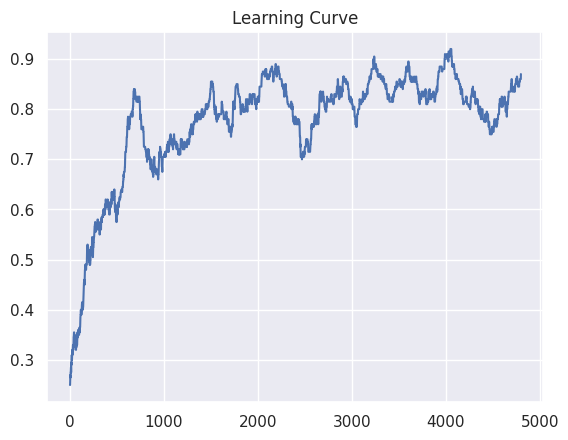

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = mc_fv_eps_greedy_train(n_games=5000,train_X=True,train_O=False,is_random=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_X_trained_mcfveg_rand = Q_X

100%|██████████| 5000/5000 [00:19<00:00, 254.02it/s]


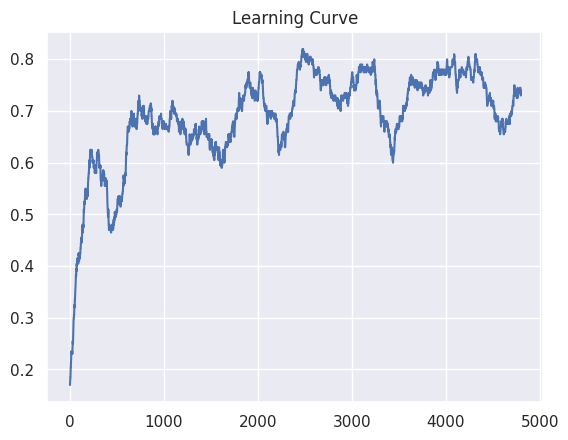

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = mc_fv_eps_greedy_train(n_games=5000,train_X=True,train_O=False,is_random=False,is_defensive=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_X_trained_mcfveg_def = Q_X

100%|██████████| 5000/5000 [00:17<00:00, 284.27it/s]


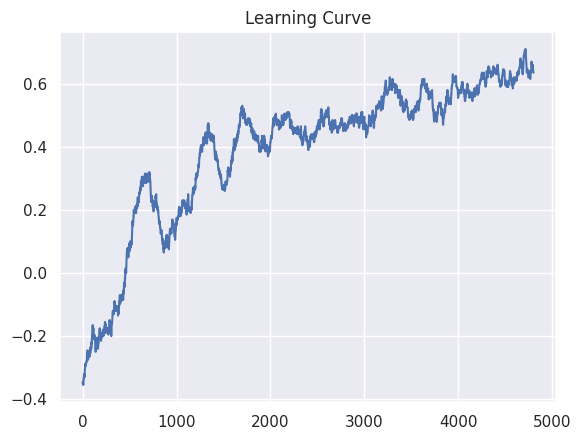

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = mc_fv_eps_greedy_train(n_games=5000,train_X=False,train_O=True,is_random=True,is_defensive=False,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_O_trained_mcfveg_rand = Q_O

100%|██████████| 5000/5000 [00:21<00:00, 235.77it/s]


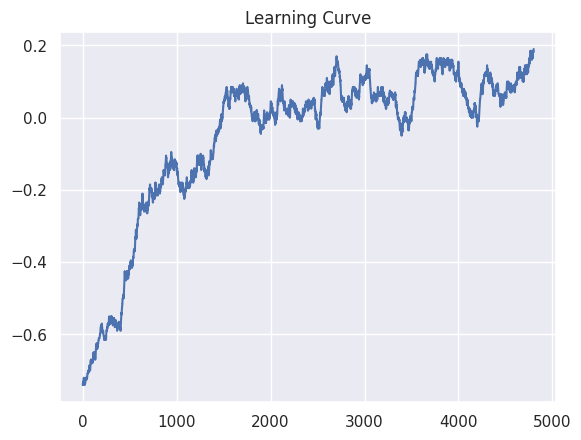

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = mc_fv_eps_greedy_train(n_games=5000,train_X=False,train_O=True,is_random=False,is_defensive=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_O_trained_mcfveg_def = Q_O

Below are the results for 2b. They show that an agent trained to play 2nd against a defensive policy tends to win (going second) against an agent trained to play 1st against a random  policy, and an agent trained to play 2nd against a random policy tends to win (going second) against an agent trained to play 1st against a defensive policy. This is kind of strange, since we would think it is harder to win playing second, but I think this is just happenstance because both policies are nearly deterministic (epsilon = 0.1) and never saw the other play during training.

In [ ]:
win_statistics = get_win_statistics(Q_X_trained_mcfveg_rand,Q_O_trained_mcfveg_def,sets = 10, games_in_set = 500,\
                                    X_strategy = 'eps_greedy', O_strategy='eps_greedy',eps_X=0.1,eps_O=0.1)

100%|██████████| 500/500 [00:01<00:00, 334.51it/s]


<Figure size 640x480 with 0 Axes>

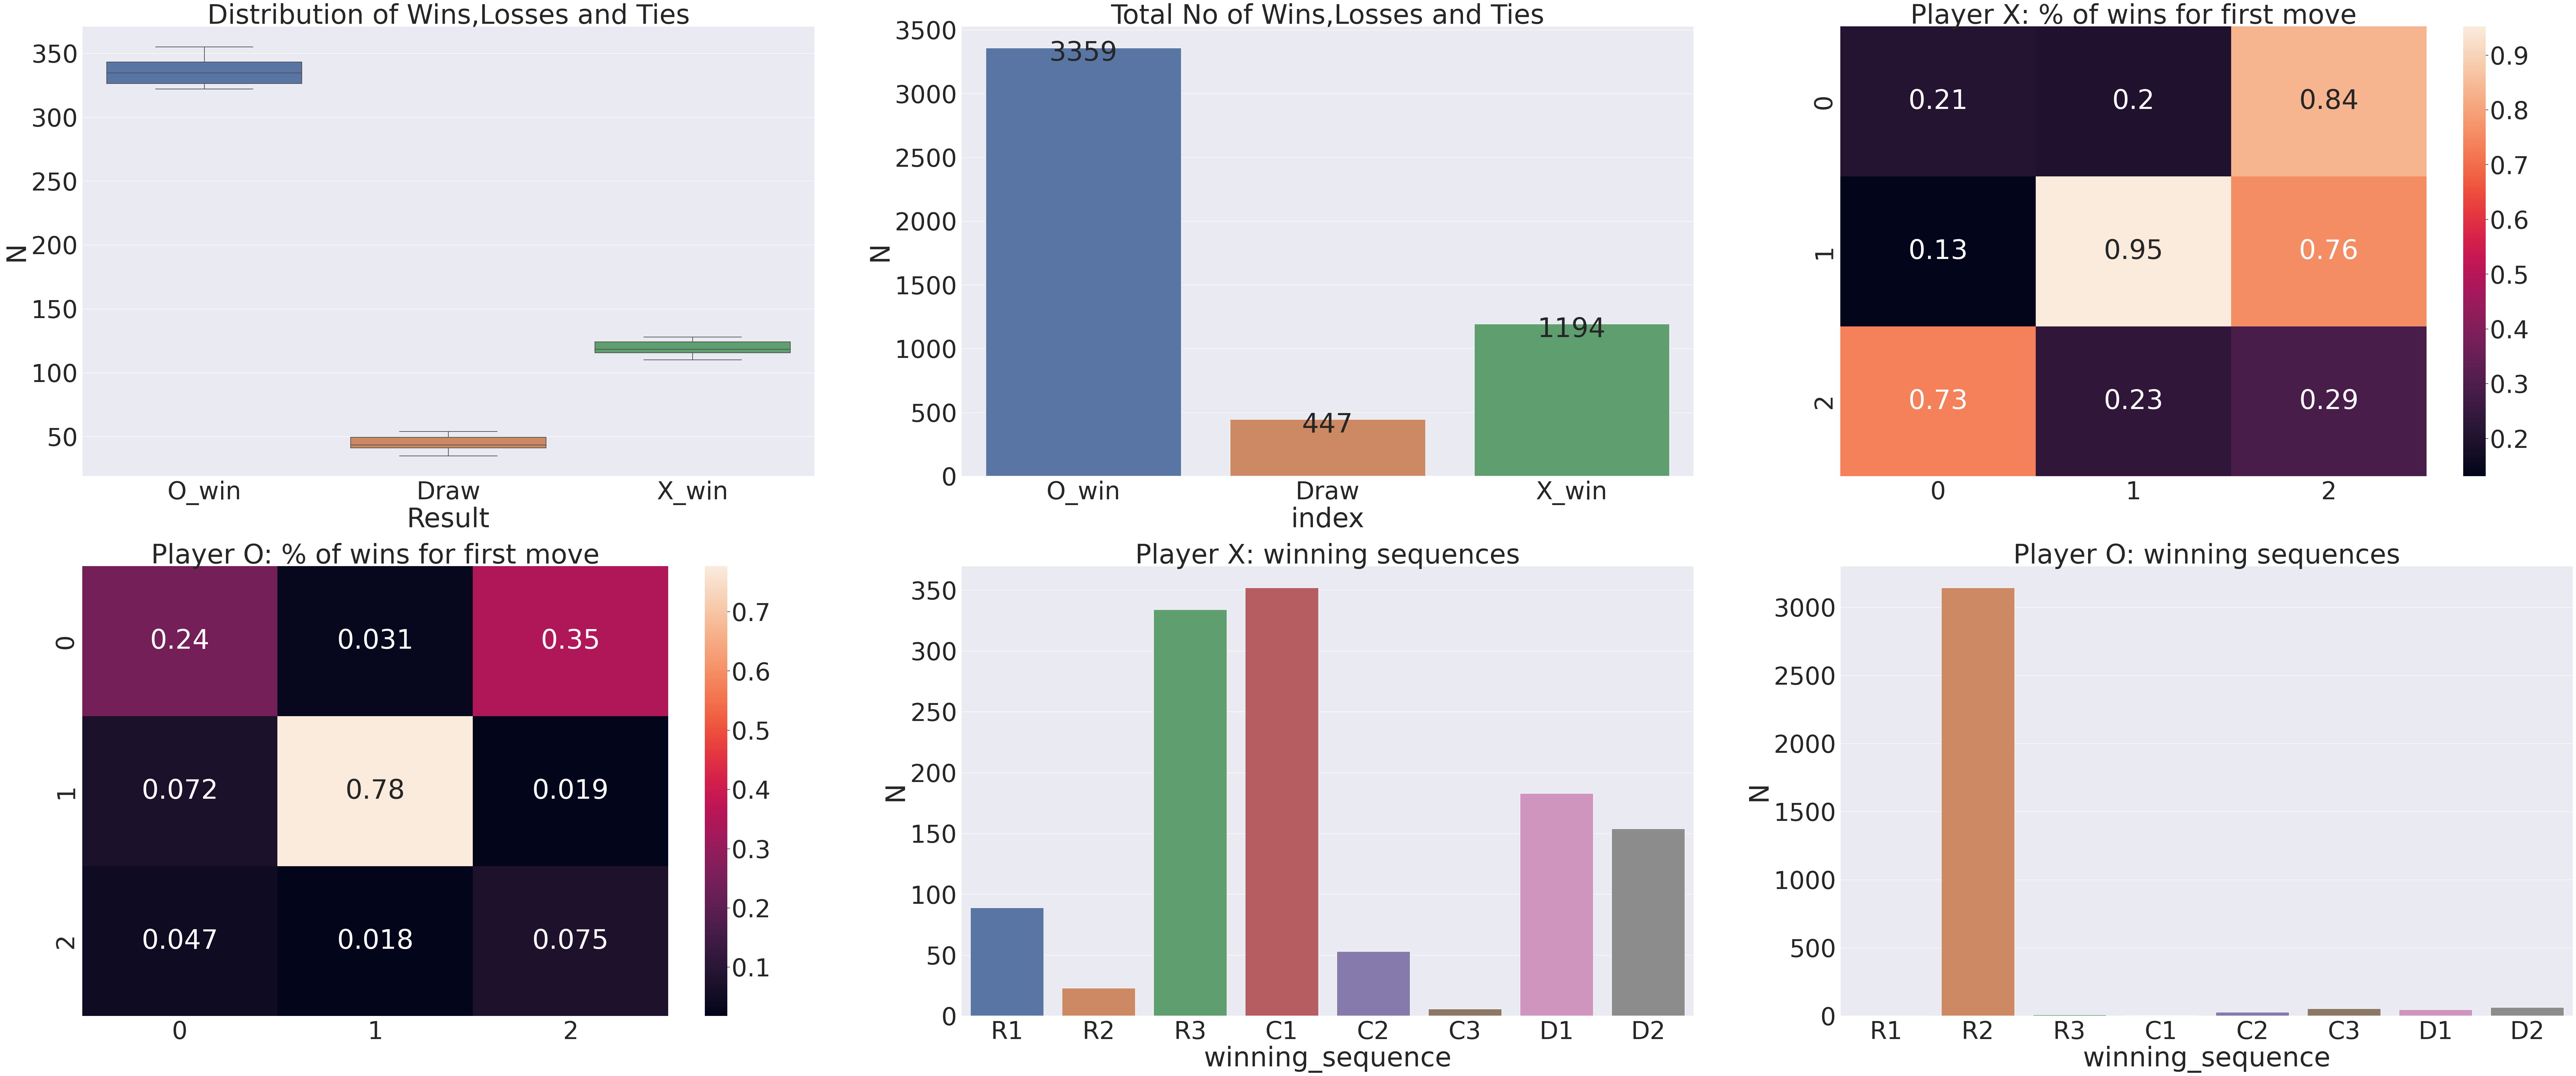

In [ ]:
plot_results(win_statistics)

In [ ]:
dict_ = {"Defensive O wins":f"{(3359/50)}%","Draw":f"{(447/50)}%","Random X wins":f"{(1194/50)}%"}

df = pd.DataFrame.from_dict(dict_, orient='index', columns=['Frequency'])
print(df)

                 Frequency
Defensive O wins    67.18%
Draw                 8.94%
Random X wins       23.88%


In [ ]:
win_statistics_xdef_vs_orand = get_win_statistics(Q_X_trained_mcfveg_def,Q_O_trained_mcfveg_rand,sets = 10, games_in_set = 500,\
                                                  X_strategy = 'eps_greedy', O_strategy='eps_greedy',eps_X=0.1,eps_O=0.1)

100%|██████████| 500/500 [00:01<00:00, 252.29it/s]


<Figure size 640x480 with 0 Axes>

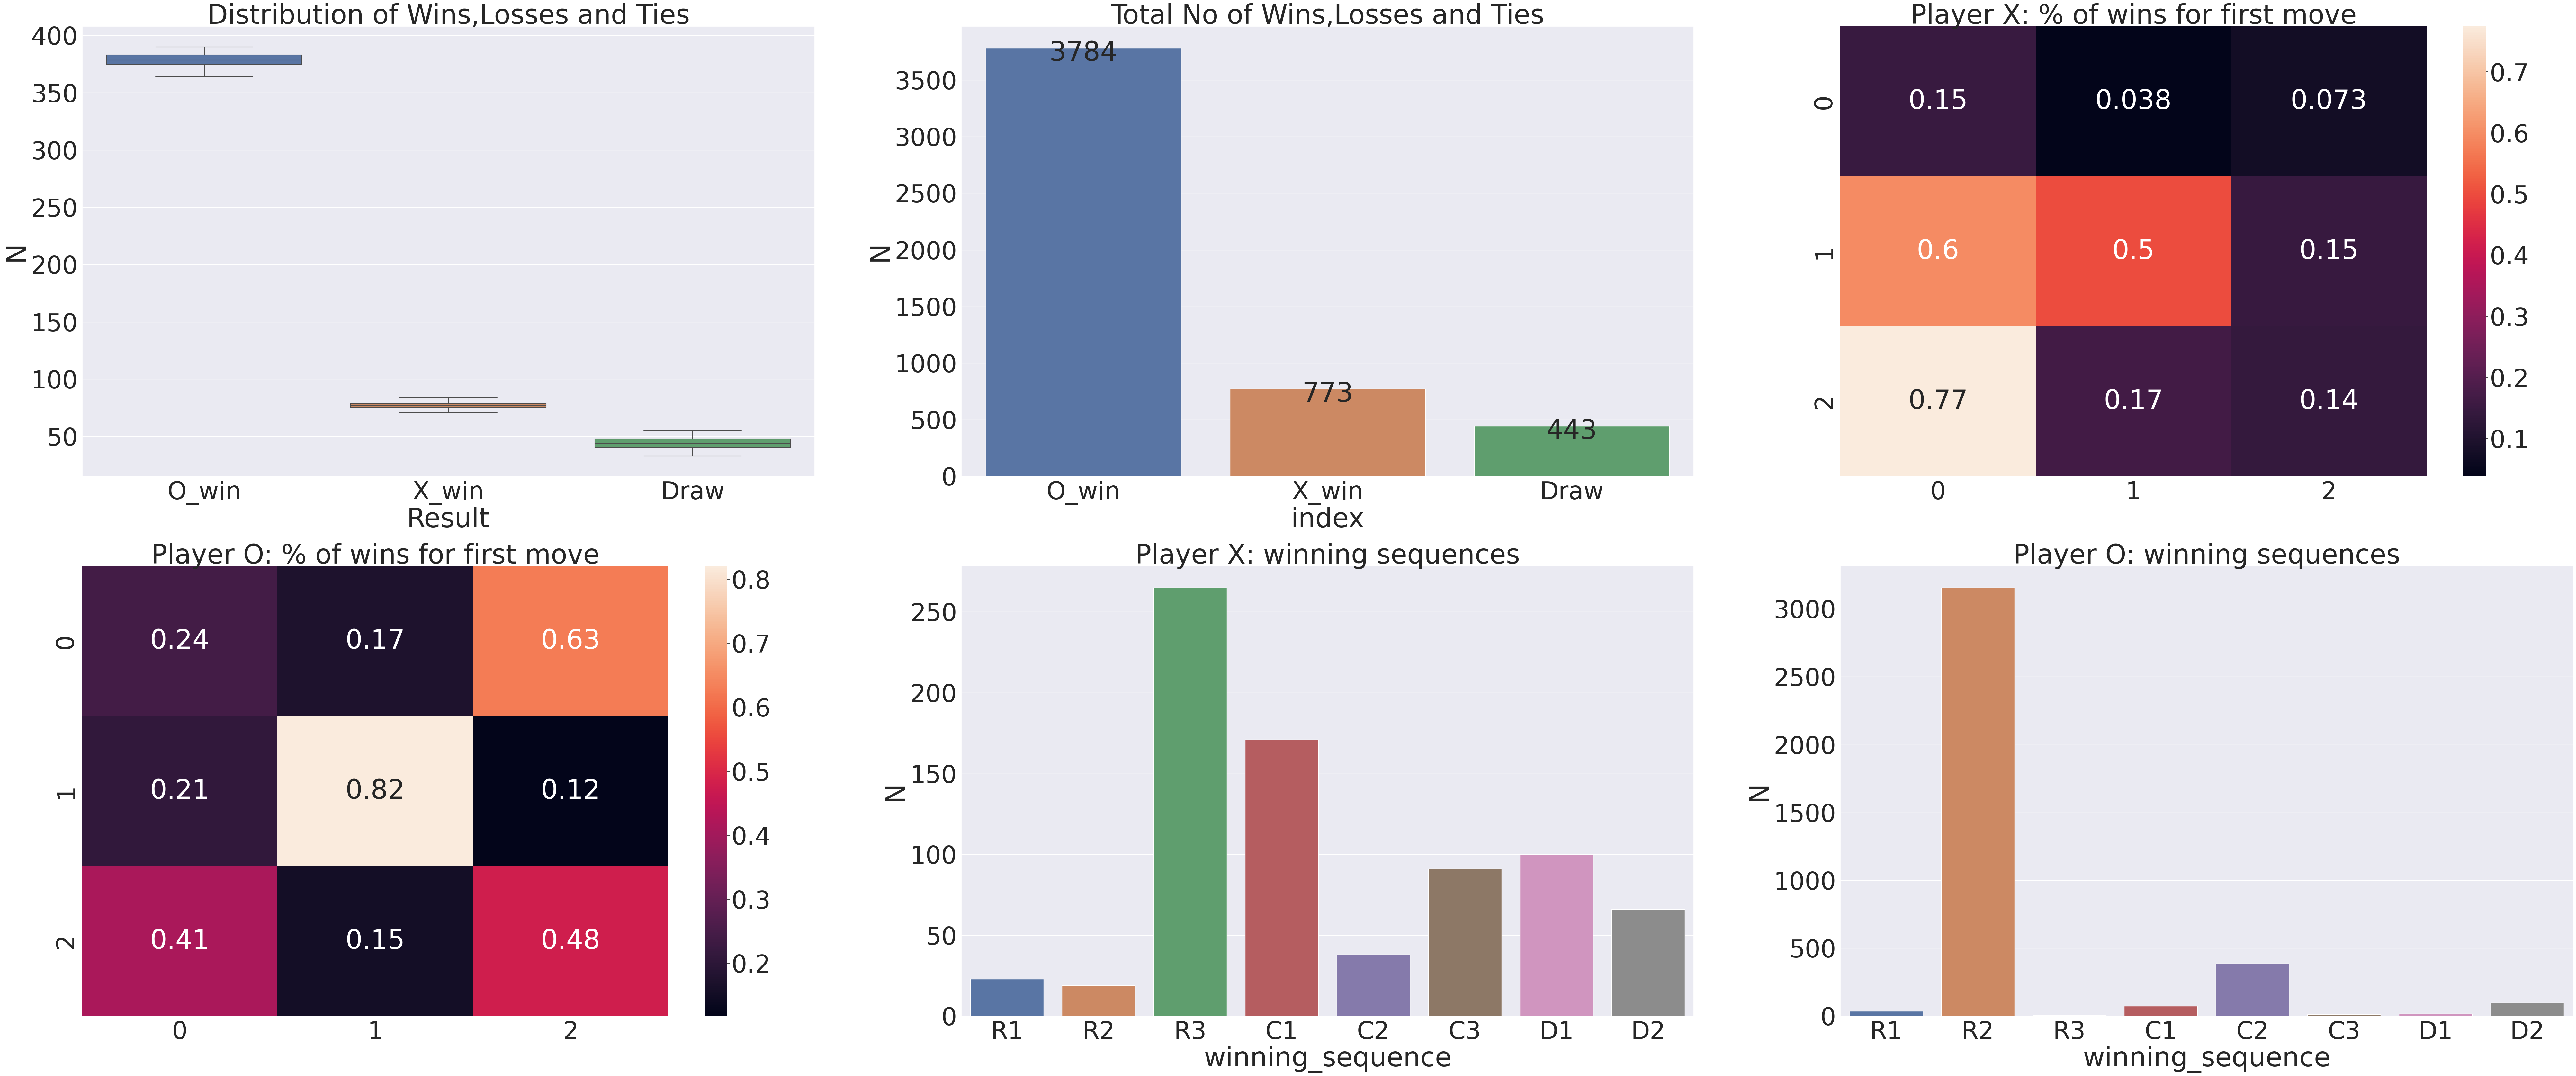

In [ ]:
plot_results(win_statistics_xdef_vs_orand)

In [ ]:
dict_ = {"Random O wins":f"{(3784/50)}%","Draw":f"{(443/50)}%","Defensive X wins":f"{(773/50)}%"}

df = pd.DataFrame.from_dict(dict_, orient='index', columns=['Frequency'])
print(df)

                 Frequency
Random O wins       75.68%
Draw                 8.86%
Defensive X wins    15.46%


#2c
Off policy MC using (weighted and unweighted) importance sampling

In [ ]:
def mc_fv_off_policy_train(n_games=1000, gamma = 1.0,train_X=True,train_O=False,is_random=True,is_defensive=False,
                           t_board_X=None,t_board_O=None,weighted=False,**kwargs):
    """
    Function to train a player in a game of tic-tac-toe
    Arguments:
        n_games: Number of games on which to train
        gamma: discount factor
        train_X: Flag indicating whether player X should be trained
        train_O: Flag inficating whether player O should be trained
        is_random: should actions of untrained agent be random
        is_defensive: should actions of untrained agent be defensive (deterministic according to Q table otherwise)    
    """
     
    
    # If Q is not provided, randomize intially, if provided, it will be used to select actions greedily
    if "Q_X" in kwargs:
        action_type_X = "greedy"
        assert train_X == False ,"Train flag should be set to False if Q table is being provided"
        Q_X = kwargs["Q_X"]
    else:
        States_X = t_board_X.my_states # Will raise an error if no t_board passed in
        Q_X = initialize_Q(States_X)
        
    if "Q_O" in kwargs:
        action_type_O = "greedy"
        assert train_O == False ,"Train flag should be set to False if Q table is being provided"
        Q_O = kwargs["Q_O"]
    else:
        States_O = t_board_O.my_states # Will raise an error if no t_board passed in
        Q_O = initialize_Q(States_O)
    
    if train_X:
      train_counts = initialize_train_counts(States_X)
    else:
      train_counts = initialize_train_counts(States_O)
    eps = 1.0 # Sample actions purely randomly if using epsilon (defensive sometimes doesn't, and our target policy won't either)
    
    
    #Lists to keep track of rewards earned by both players during training
    
    rewards_X = []
    rewards_O = []
    
    
    if train_X:
        X_action_type = 'eps_greedy' # Turns into pure random
    else:
        X_action_type = 'greedy'
        if is_random:
            X_action_type = 'eps_greedy'  # Turns into pure random
        elif is_defensive:
            X_action_type = 'defensive'
        
            
    
    if train_O:
        O_action_type = 'eps_greedy'  # Turns into pure random
    else:
        O_action_type = 'greedy'
        if is_random:
            O_action_type = 'eps_greedy'  # Turns into pure random
        elif is_defensive:
            O_action_type = 'defensive'
            
    for i in tqdm(range(n_games),position=0,leave=True):
        
        episode_train_states = []
        episode_train_actions = []
        
        t_board_X.reset_board()
        t_board_O.reset_board()

        #X lands on empty board
        S_X = t_board_X.board_to_state()
        
        #X plays first
            
        x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
        x_action1d = t_board_X.b2_to_s1[x_action]

        if train_X:
          episode_train_states.append(S_X)
          episode_train_actions.append(x_action1d)
        
        R_X = t_board_X.my_move(x_action) # make move on X's board
        t_board_O.opponent_move(x_action) # make same move on O's board

        while not (t_board_X.is_game_over() or t_board_O.is_game_over()):
            S_O = t_board_O.board_to_state()
            
            #O plays second            
            
            o_action = t_board_O.pick_best_action(Q_O,action_type=O_action_type,eps=eps)
            o_action1d = t_board_O.b2_to_s1[o_action]
            R_O = t_board_O.my_move(o_action) #make move on O's board
            t_board_X.opponent_move(o_action) #make same move on X's board

            if train_O:
              episode_train_states.append(S_O)
              episode_train_actions.append(o_action1d)

            if  t_board_O.is_game_over(): 
                #need to end game here if O makes the winnng move and add a reward 
                if train_O:
                    # Adding for MC
                    G = 0 # Return
                    W = 1
                    for t in range(1,len(episode_train_states)+1):
                      G = R_O if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      count_update = W if weighted else 1
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += count_update
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      update = (G-curr_q)/(counts+1)
                      if weighted:
                        update *= W
                      Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]] += update
                      W *= len(t_board_O.possible_actions(episode_train_states[-1*t])) 
                      # ^ 1 / (probability of this action given this state with random policy)
                
                if train_X:
                    # Adding for MC
                    # Need to penalize X's previous action if game is over
                    G = 0 # Return
                    W = 1
                    for t in range(1,len(episode_train_states)+1):
                      G = -R_O if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      count_update = W if weighted else 1
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += count_update
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      update = (G-curr_q)/(counts+1)
                      if weighted:
                        update *= W
                      Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]] += update
                      W *= len(t_board_X.possible_actions(episode_train_states[-1*t])) 
                      # ^ 1 / (probability of this action given this state with random policy)
                
                rewards_O.append(R_O)
                rewards_X.append(-R_O)
                break
        
            S_X = t_board_X.board_to_state()

            # X plays next
            x_action = t_board_X.pick_best_action(Q_X,action_type = X_action_type,eps=eps)
            x_action1d = t_board_X.b2_to_s1[x_action]
            R_X = t_board_X.my_move(x_action) #make move on X's board
            t_board_O.opponent_move(x_action) #make same move on O's board

            if train_X:
              episode_train_states.append(S_X)
              episode_train_actions.append(x_action1d)

            if t_board_X.is_game_over(): 
                if train_O:
                    # Adding for MC
                    G = 0 # Return
                    W = 1
                    for t in range(1,len(episode_train_states)+1):
                      G = -R_X if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      count_update = W if weighted else 1
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += count_update
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      update = (G-curr_q)/(counts+1)
                      if weighted:
                        update *= W
                      Q_O[episode_train_states[-1*t]][episode_train_actions[-1*t]] += update
                      W *= len(t_board_O.possible_actions(episode_train_states[-1*t])) 
                      # ^ 1 / (probability of this action given this state with random policy)
                
                if train_X:
                    # Adding for MC
                    # Need to reward X's winning action if game is over
                    G = 0 # Return
                    W = 1
                    for t in range(1,len(episode_train_states)+1):
                      G = R_X if t == 1 else gamma*G # Only get rewards at the end of a game
                      curr_q = Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      count_update = W if weighted else 1
                      train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]] += count_update
                      counts = train_counts[episode_train_states[-1*t]][episode_train_actions[-1*t]]
                      update = (G-curr_q)/(counts+1)
                      if weighted:
                        update *= W
                      Q_X[episode_train_states[-1*t]][episode_train_actions[-1*t]] += update
                      W *= len(t_board_X.possible_actions(episode_train_states[-1*t])) 
                      # ^ 1 / (probability of this action given this state with random policy)
                
                rewards_X.append(R_X)
                rewards_O.append(-R_X)
                break
            
    if train_X:
        rewards = rewards_X
    elif train_O:
        rewards = rewards_O
        
    sns.set(font_scale=1)
    m_avg = moving_average(rewards,w=200)
    sns.lineplot(x=range(len(m_avg)),y=m_avg).set_title('Learning Curve')
    plt.show()
        
    return Q_X,Q_O,rewards_X,rewards_O

100%|██████████| 5000/5000 [00:18<00:00, 266.41it/s]


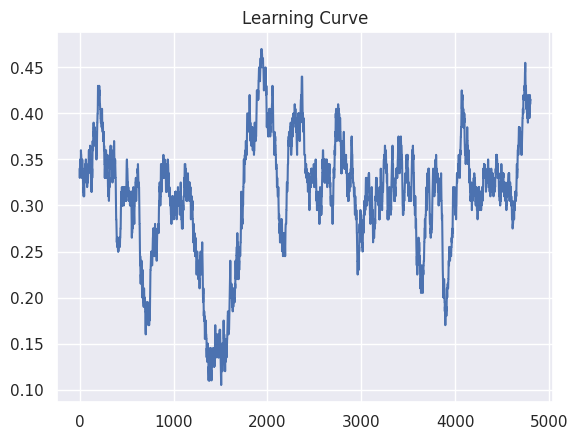

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=True,train_O=False,is_random=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_X_trained_mcfvop_unw_rand = Q_X

The behavior policy is random, so the above poor performance is expected during training. The target policy will be better!

100%|██████████| 5000/5000 [00:28<00:00, 174.92it/s]


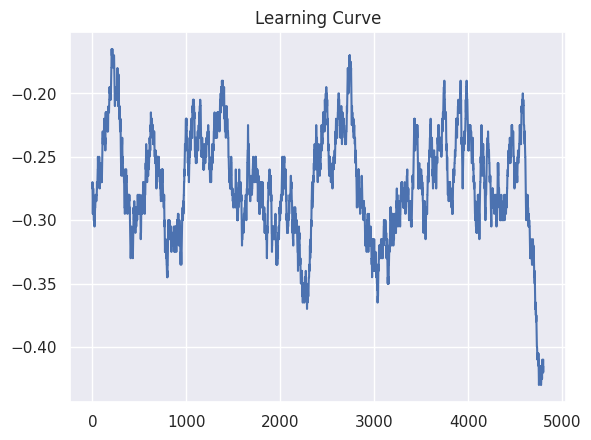

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=True,train_O=False,is_random=False,is_defensive=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_X_trained_mcfvop_unw_def = Q_X

100%|██████████| 5000/5000 [00:18<00:00, 269.69it/s]


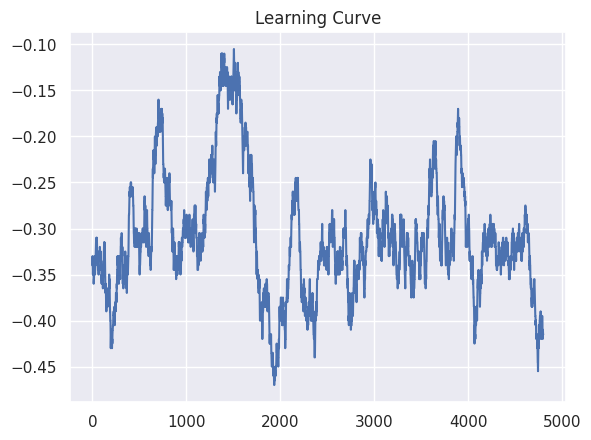

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=False,train_O=True,is_random=True,is_defensive=False,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_O_trained_mcfvop_unw_rand = Q_O

100%|██████████| 5000/5000 [00:28<00:00, 174.43it/s]


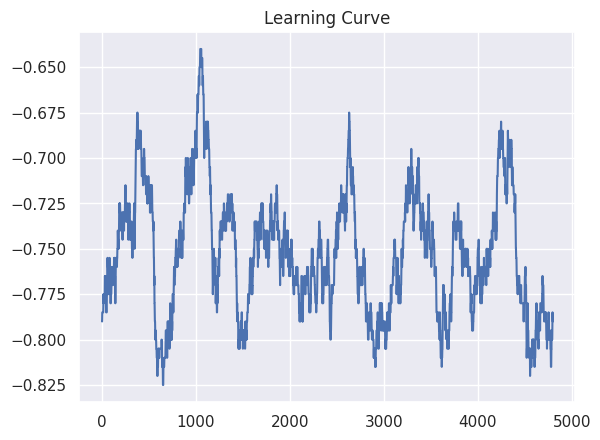

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=False,train_O=True,is_random=False,is_defensive=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O)
Q_O_trained_mcfvop_unw_def = Q_O

In [ ]:
win_statistics_rand1 = get_win_statistics(Q_X_trained_mcfvop_unw_rand,Q_O_trained_mcfvop_unw_def,sets = 10, games_in_set = 500,\
                                    X_strategy = 'greedy', O_strategy='greedy',eps_X=0.1,eps_O=1.0)

100%|██████████| 500/500 [00:00<00:00, 548.58it/s]


<Figure size 640x480 with 0 Axes>

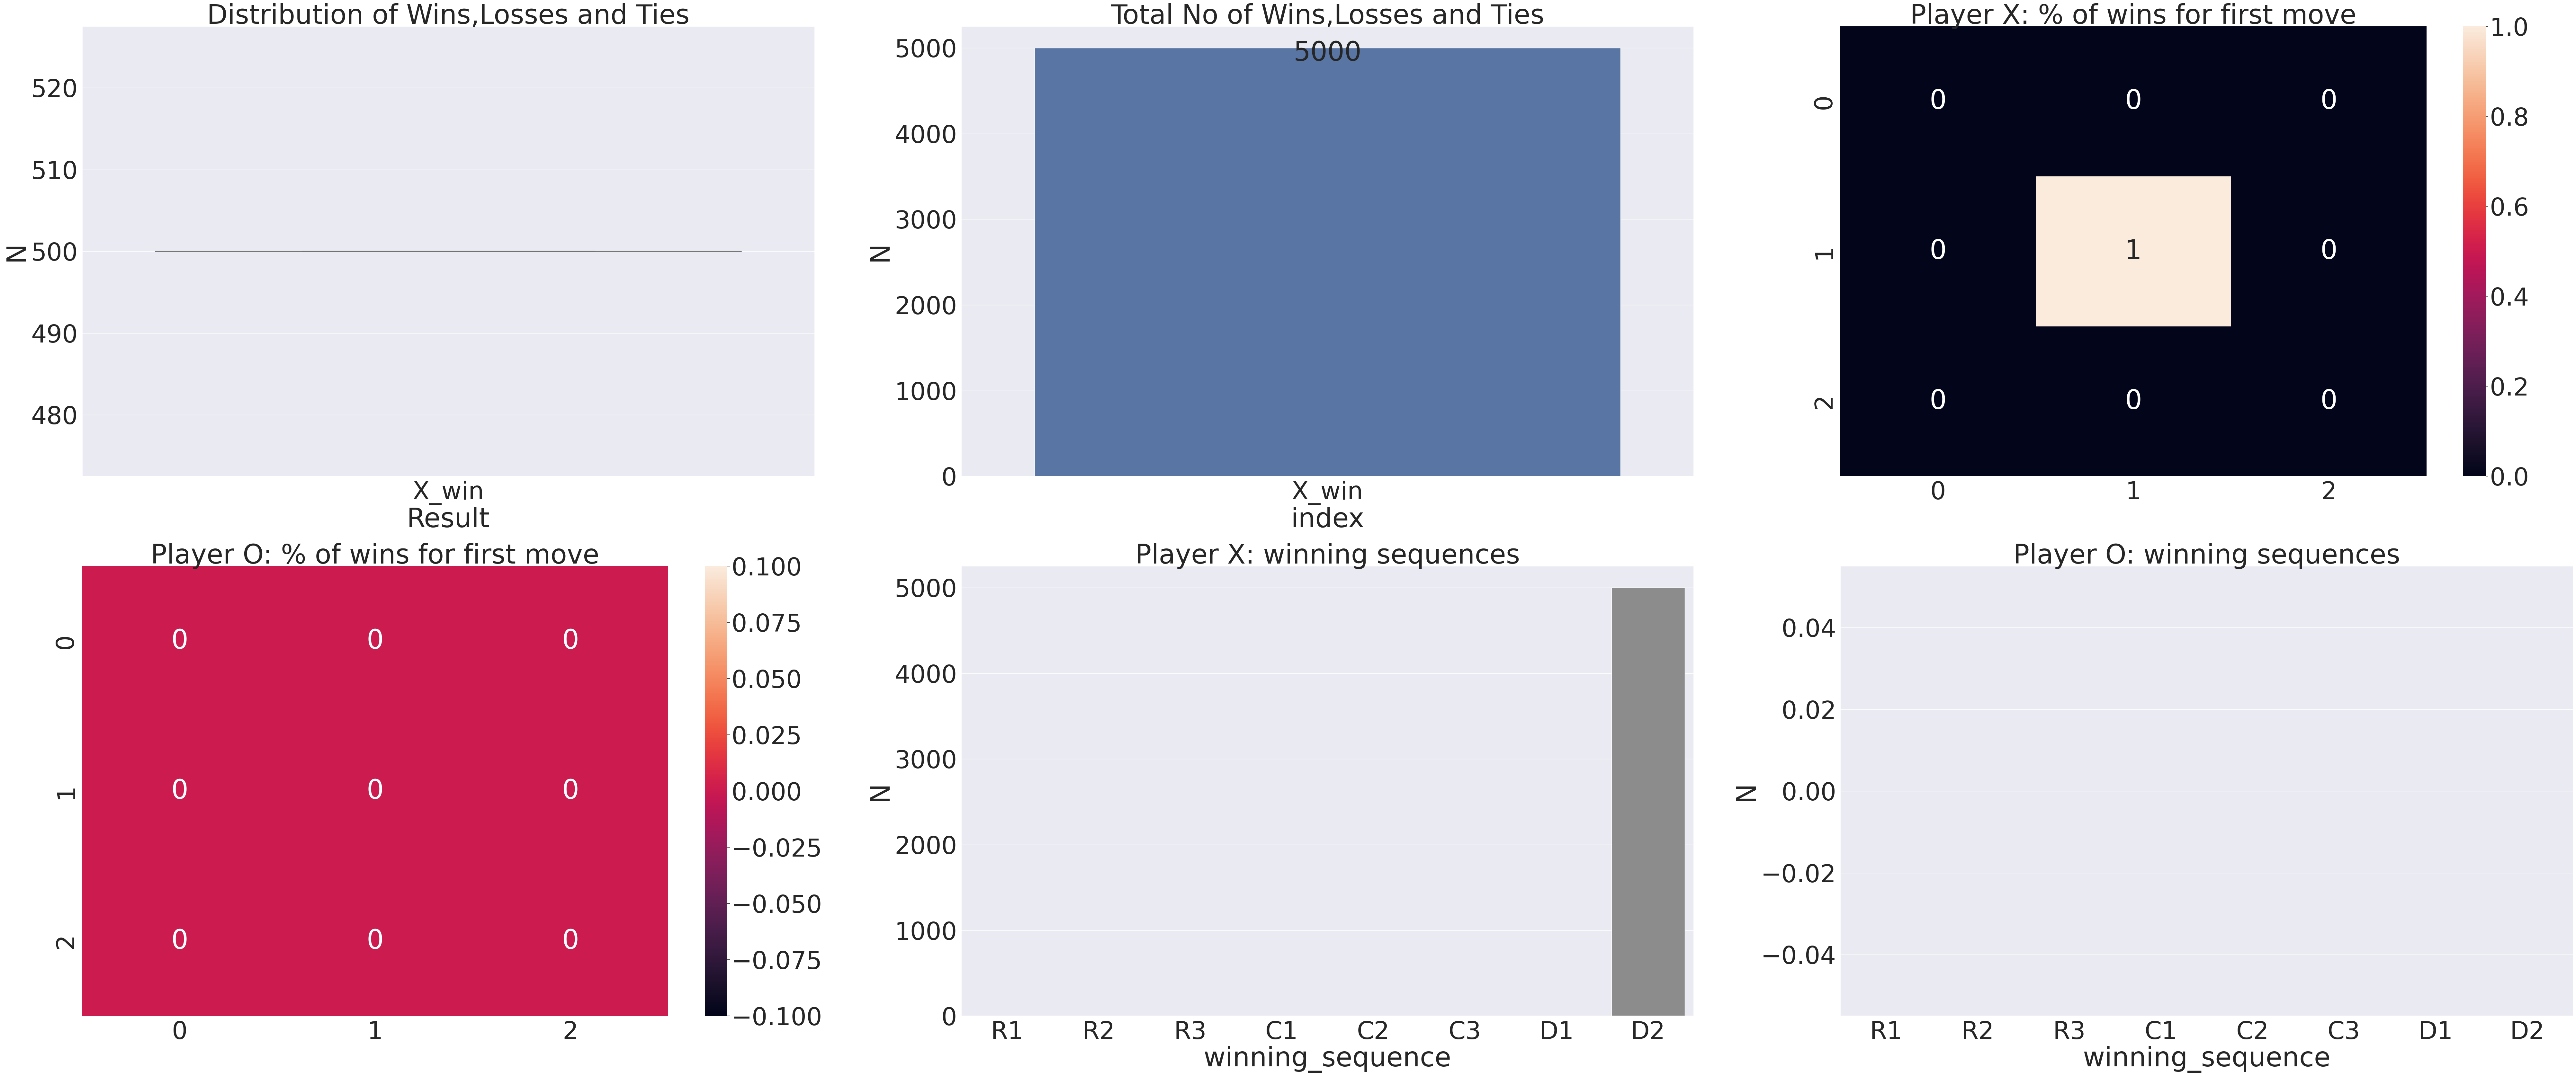

In [ ]:
plot_results(win_statistics_rand1)

All trained policies in 2c are deterministic, so the result of every game between two trained agents is determined before it begins. As such, I will only run 50 games each (to show that the result is deterministic). 

The above cell shows that the player 1 model trained against a random policy beats the player 2 model trained against a defensive policy (100% of the time).

In [ ]:
win_statistics_def1 = get_win_statistics(Q_X_trained_mcfvop_unw_def,Q_O_trained_mcfvop_unw_rand,sets = 1, games_in_set = 50,\
                                    X_strategy = 'greedy', O_strategy='greedy',eps_X=0.1,eps_O=1.0)

100%|██████████| 50/50 [00:00<00:00, 239.38it/s]


<Figure size 640x480 with 0 Axes>

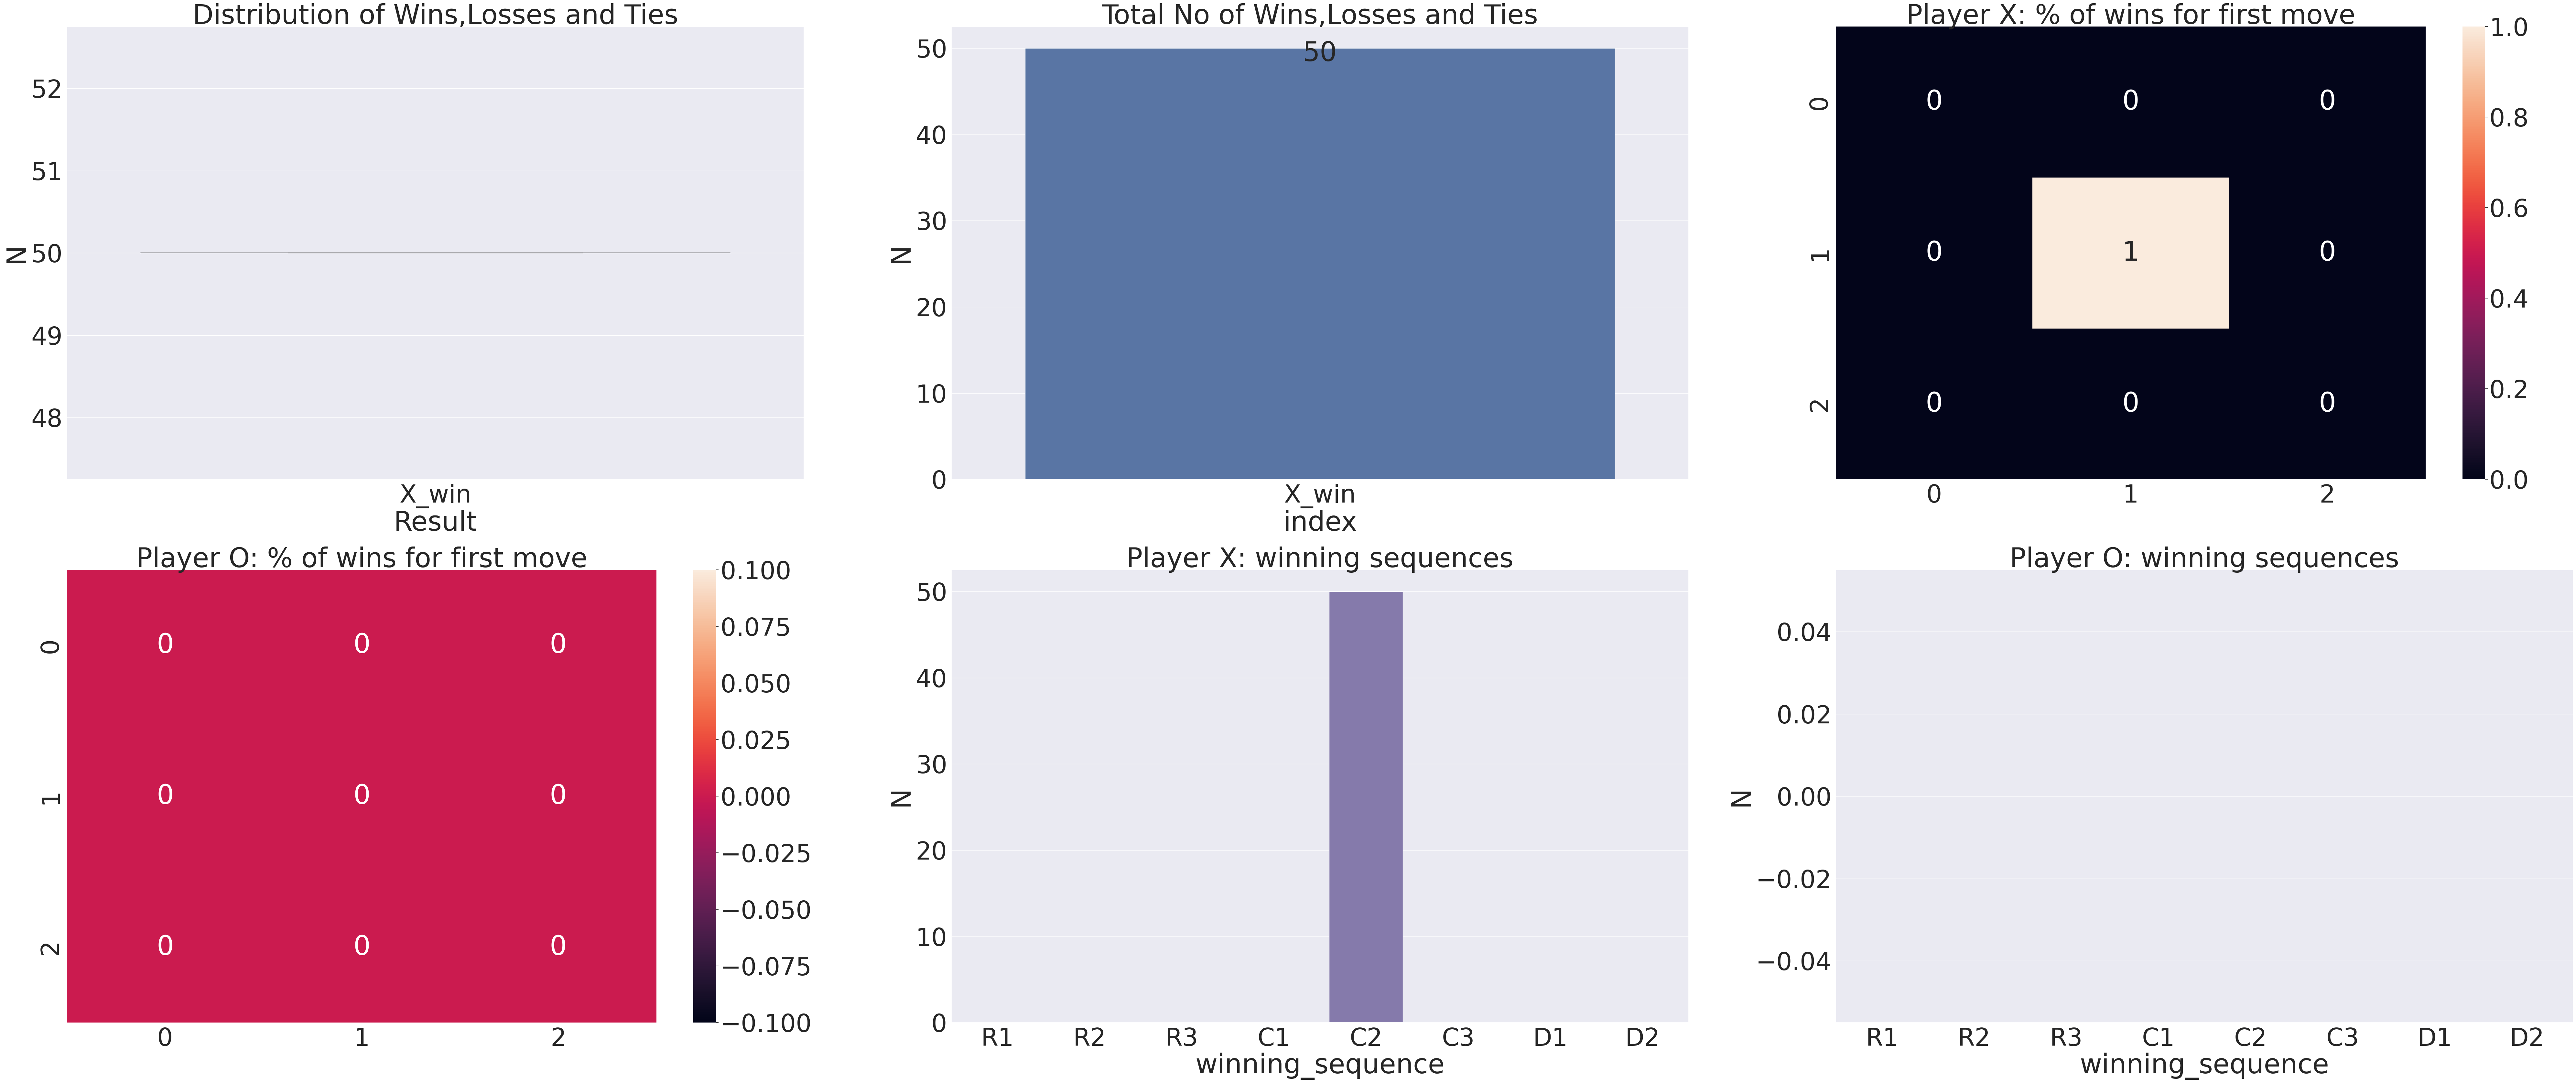

In [ ]:
plot_results(win_statistics_def1)

The above cell shows that the player 1 model trained against a defensive policy beats the player 2 model trained against a random policy (100% of the time).

Now I'll repeat with weighted importance sampling.

100%|██████████| 5000/5000 [00:26<00:00, 187.20it/s]


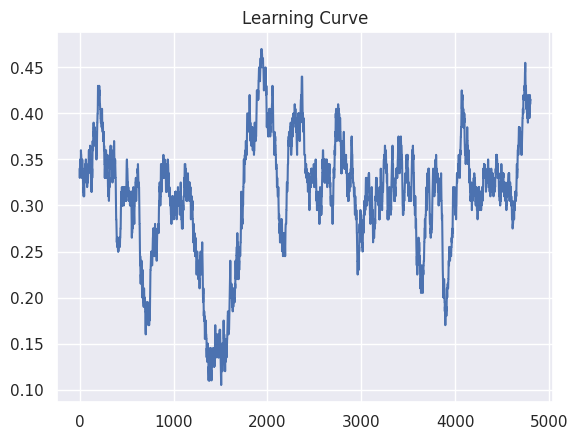

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=True,train_O=False,is_random=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O,weighted=True)
Q_X_trained_mcfvop_w_rand = Q_X

100%|██████████| 5000/5000 [00:35<00:00, 140.33it/s]


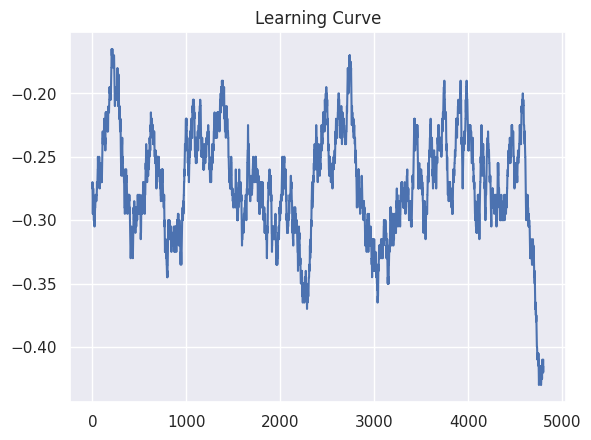

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
Q_X,_,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=True,train_O=False,is_random=False,is_defensive=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O,weighted=True)
Q_X_trained_mcfvop_w_def = Q_X

100%|██████████| 5000/5000 [00:31<00:00, 157.56it/s]


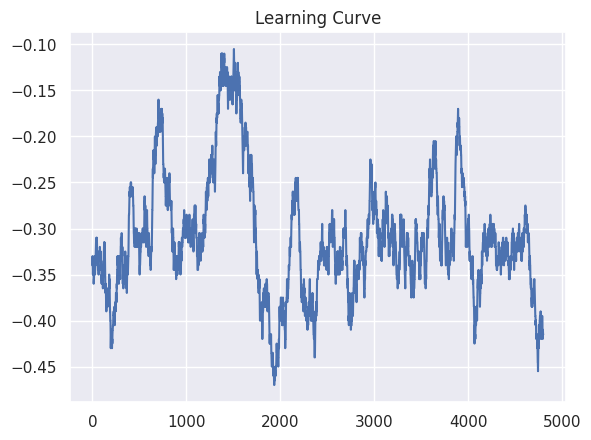

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=False,train_O=True,is_random=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O,weighted=True)
Q_O_trained_mcfvop_w_rand = Q_O

100%|██████████| 5000/5000 [00:20<00:00, 246.97it/s]


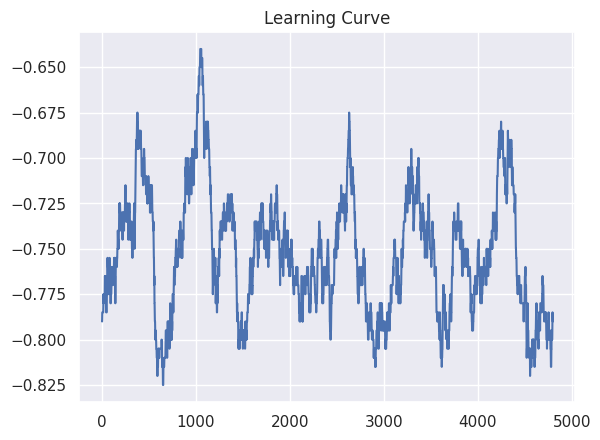

In [ ]:
np.random.seed(1)
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_O = TicTacToe(player = 'O',reward_type ='goal_reward')
#,_,rewards_X,rewards_O = train(Q_X, Q_O,n_games=8000,alpha = 0.5, gamma = 0.9,train_X=True,train_O=False)
_,Q_O,rewards_X,rewards_O = mc_fv_off_policy_train(n_games=5000,train_X=False,train_O=True,is_random=False,is_defensive=True,
                                                   t_board_X=t_board_X,t_board_O=t_board_O,weighted=True)
Q_O_trained_mcfvop_w_def = Q_O

In [ ]:
win_statistics_w_rand1 = get_win_statistics(Q_X_trained_mcfvop_w_rand,Q_O_trained_mcfvop_w_def,sets = 1, games_in_set = 50,\
                                    X_strategy = 'greedy', O_strategy='greedy',eps_X=0.1,eps_O=1.0)

100%|██████████| 50/50 [00:00<00:00, 407.61it/s]


<Figure size 640x480 with 0 Axes>

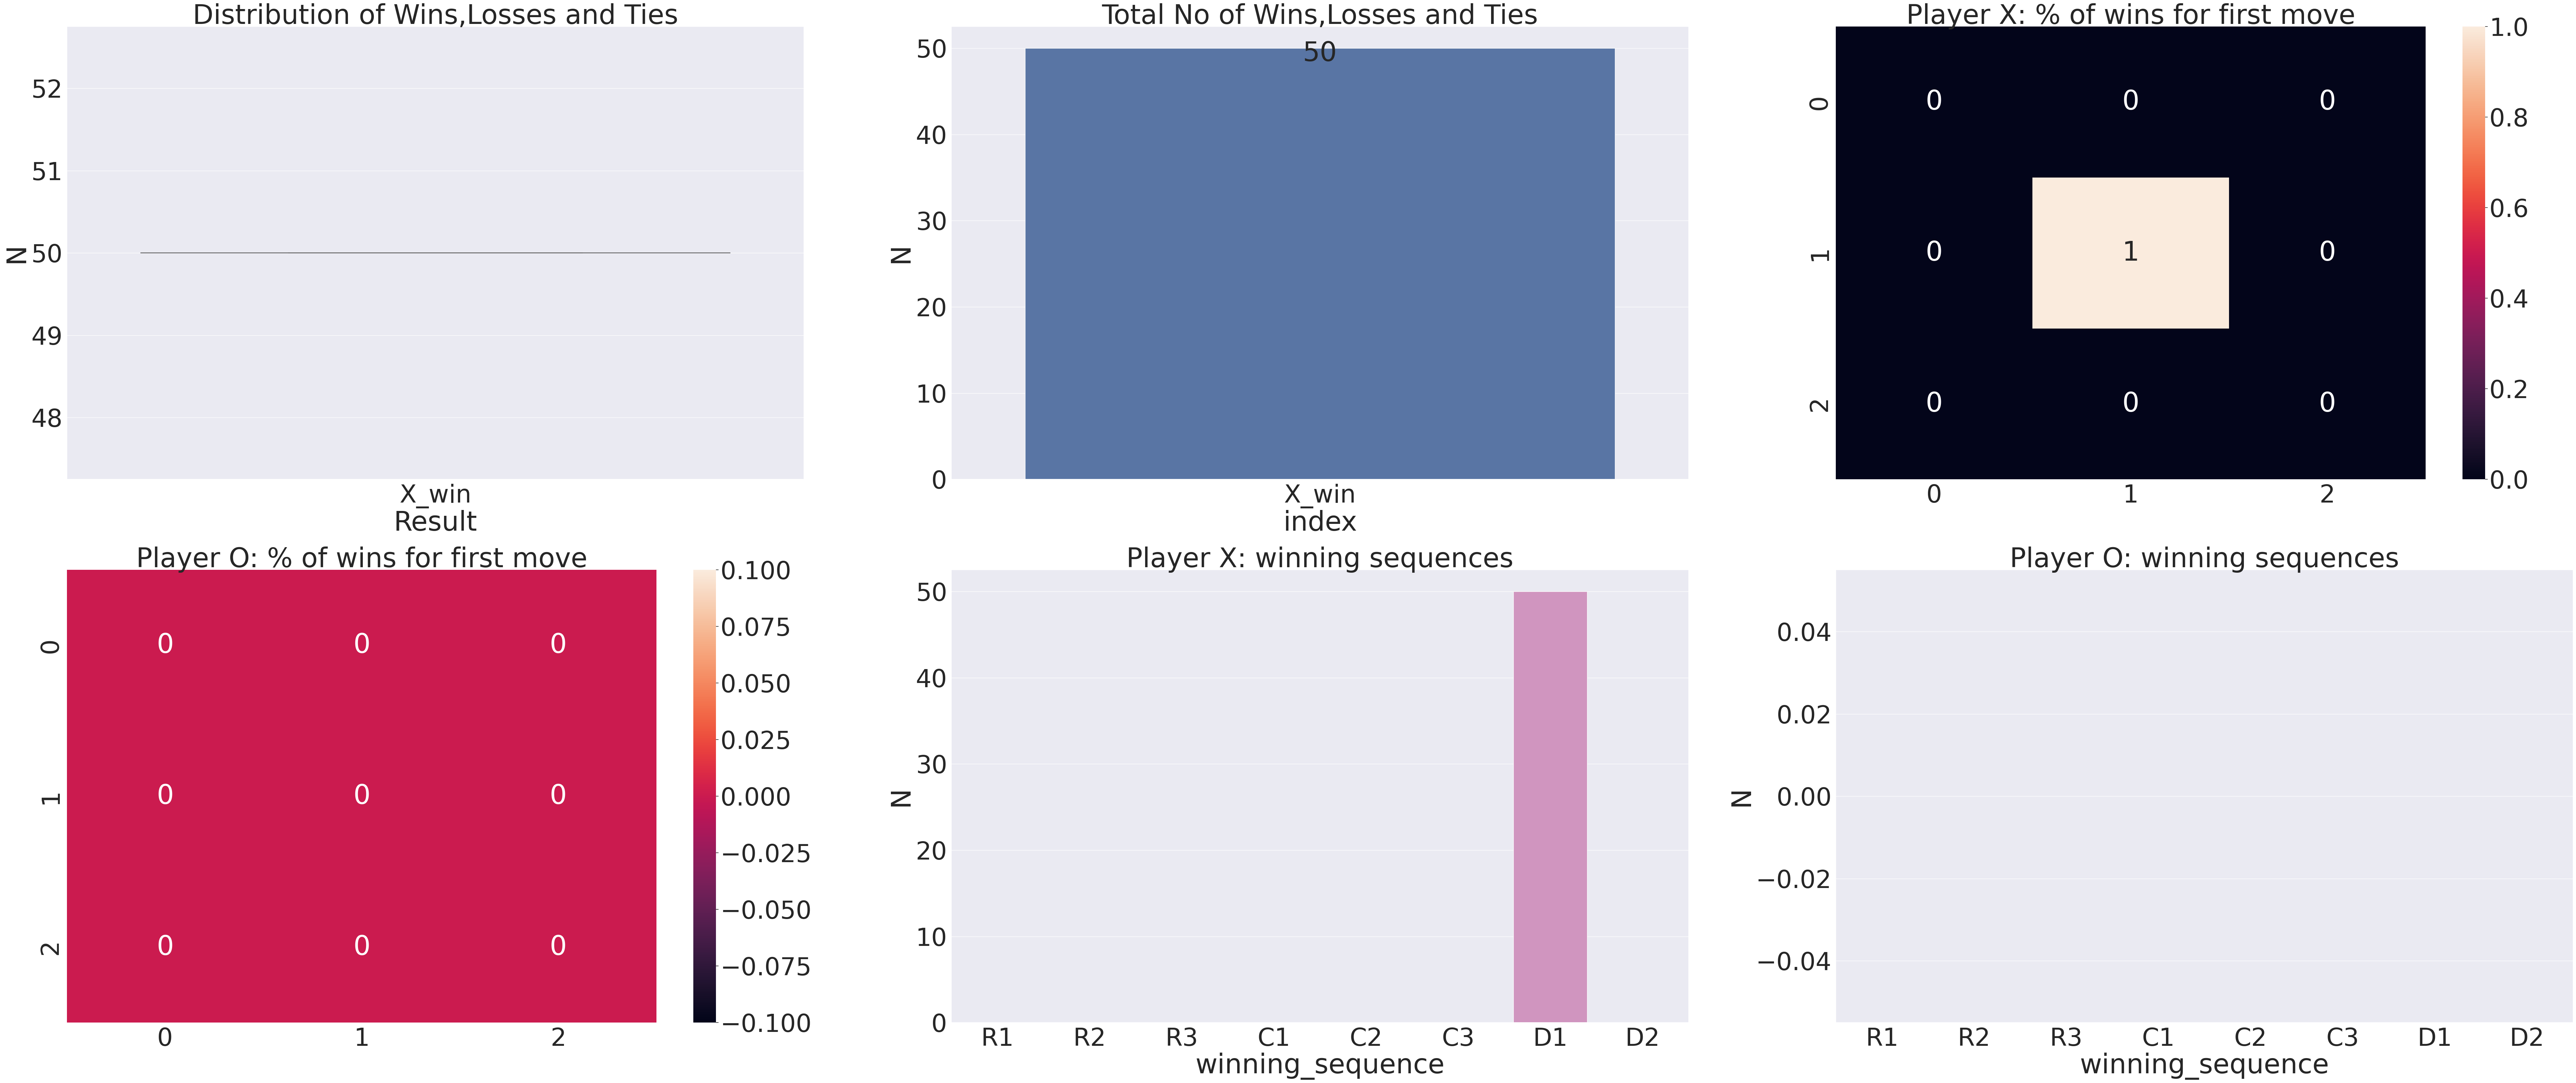

In [ ]:
plot_results(win_statistics_w_rand1)

The above cell shows that the player 1 model trained against a random policy beats the player 2 model trained against a defensive policy (100% of the time).

In [ ]:
win_statistics_w_def1 = get_win_statistics(Q_X_trained_mcfvop_w_def,Q_O_trained_mcfvop_w_rand,sets = 1, games_in_set = 50,\
                                    X_strategy = 'greedy', O_strategy='greedy',eps_X=0.1,eps_O=1.0)

100%|██████████| 50/50 [00:00<00:00, 90.24it/s]


<Figure size 640x480 with 0 Axes>

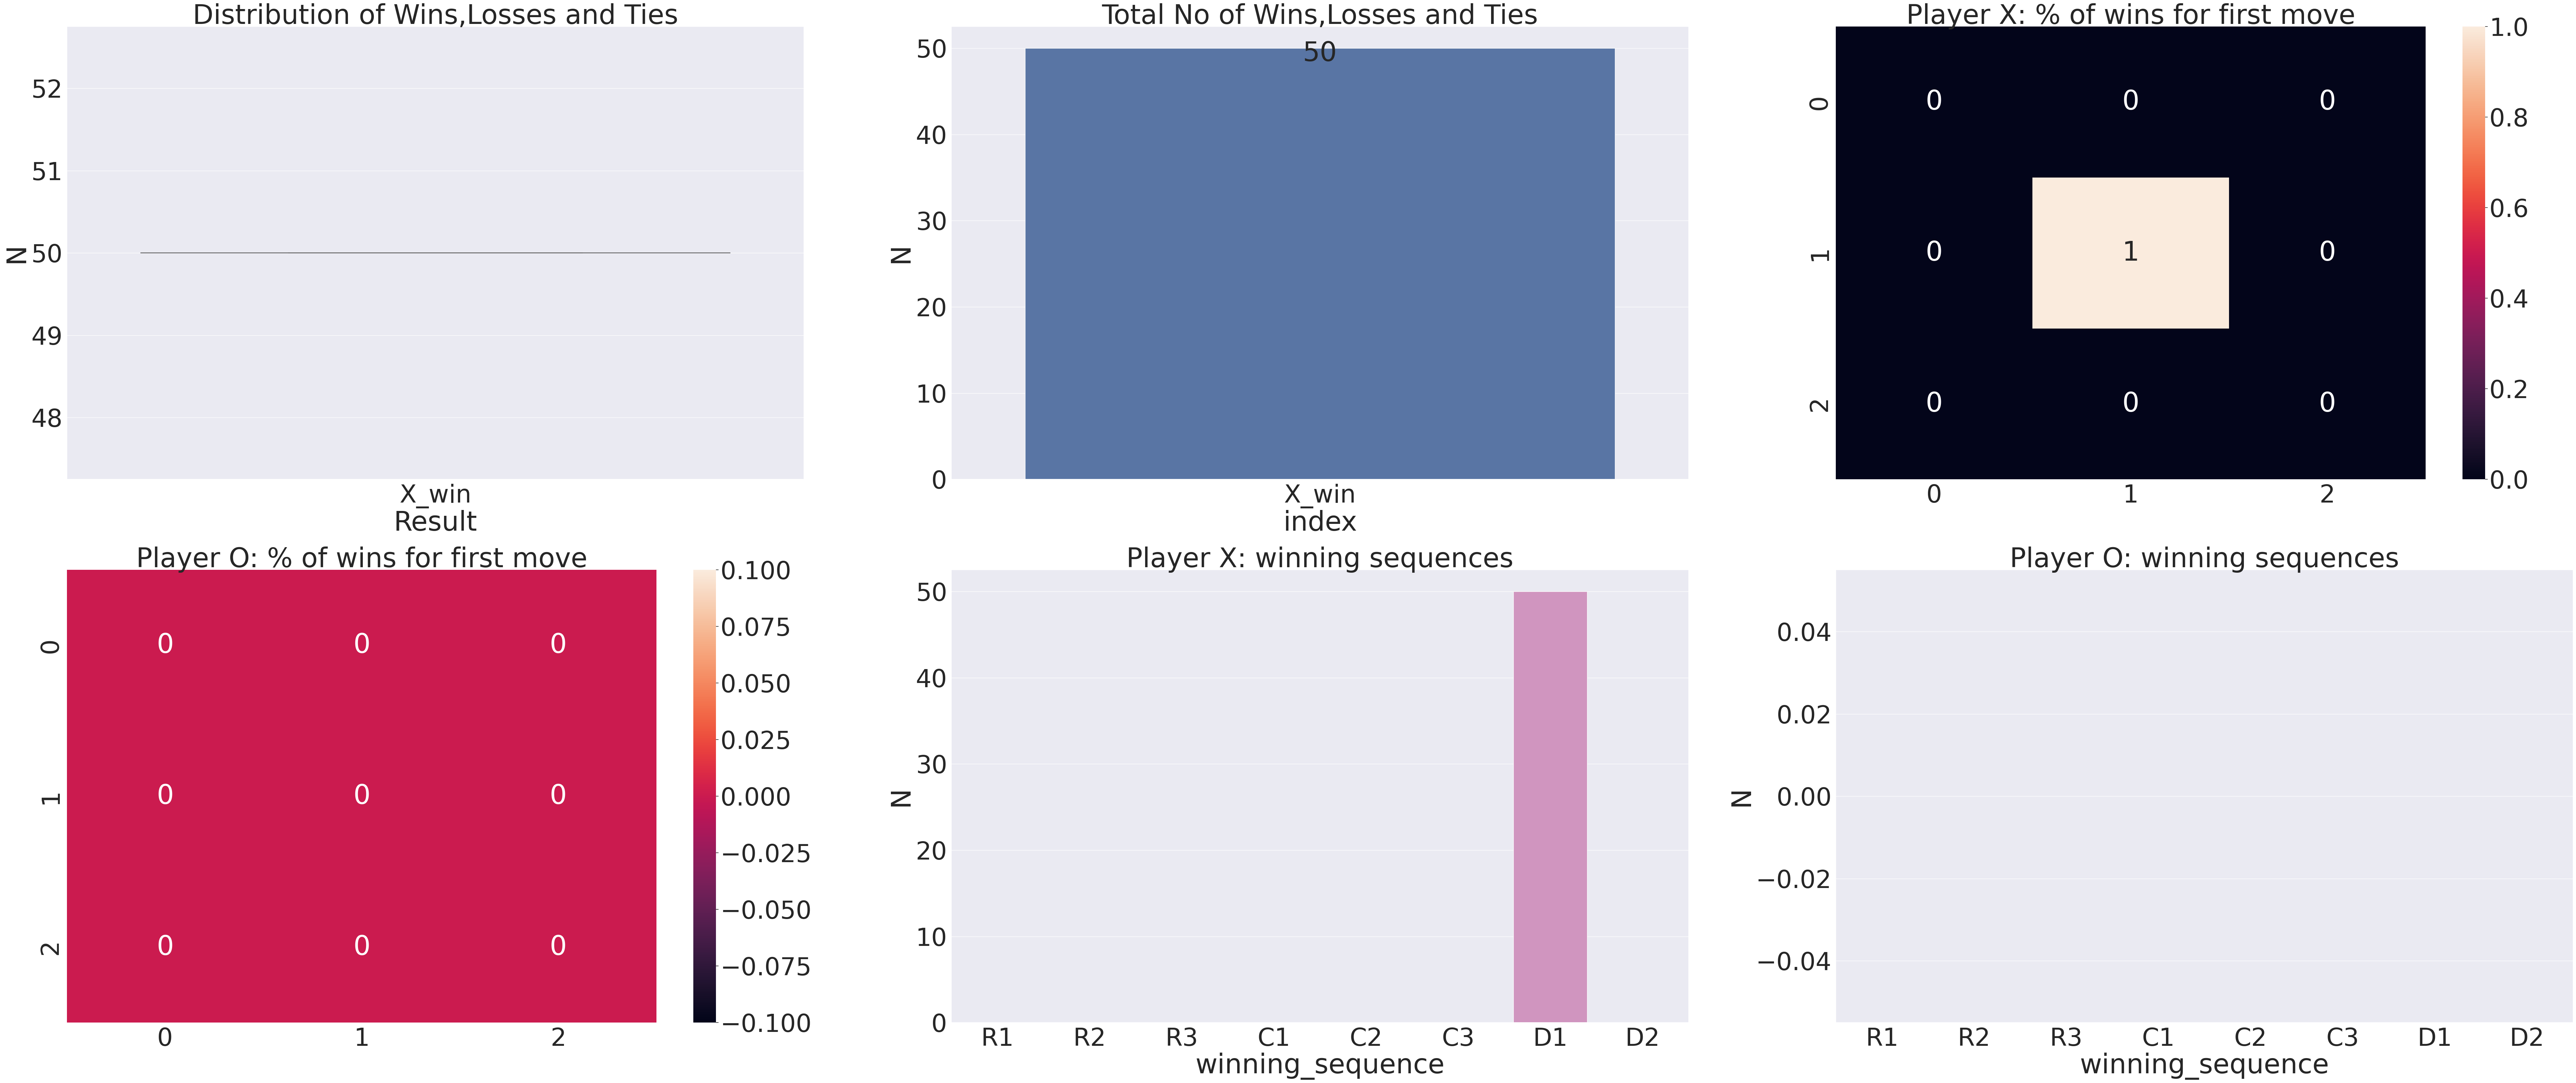

In [ ]:
plot_results(win_statistics_w_def1)

The above cell shows that the player 1 model trained against a defensive policy beats the player 2 model trained against a random policy (100% of the time).

## 2d
Playing all models against each other.

In [ ]:
win_statistics_test2 = get_win_statistics(Q_X_trained_mcfveg_rand,Q_O_trained_mcfvop_w_def,sets = 1, games_in_set = 50,\
                                    X_strategy = 'eps_greedy', O_strategy='eps_greedy',eps_X=0.1,eps_O=1.0)

100%|██████████| 50/50 [00:00<00:00, 334.46it/s]


In [ ]:
model_names = ["Random","Defensive","MC On-Policy vs Rand","MC Unweighted vs Rand","MC Weighted vs Rand","MC On-Policy vs Def",
               "MC Unweighted vs Def","MC Weighted vs Def"]

params_dict = {}

# Some parameters don't matter and are just placeholders

params_dict["Random"] = [(Q_X_trained_mcfvop_w_def,'eps_greedy',1.0),(Q_O_trained_mcfvop_w_def,'eps_greedy',1.0)]
params_dict["Defensive"] = [(Q_X_trained_mcfvop_w_def,'defensive',1.0),(Q_O_trained_mcfvop_w_def,'defensive',1.0)]
params_dict["MC On-Policy vs Rand"] = [(Q_X_trained_mcfveg_rand,'eps_greedy',0.1),(Q_O_trained_mcfveg_rand,'eps_greedy',0.1)]
params_dict["MC On-Policy vs Def"] = [(Q_X_trained_mcfveg_def,'eps_greedy',0.1),(Q_O_trained_mcfveg_def,'eps_greedy',0.1)]
params_dict["MC Unweighted vs Rand"] = [(Q_X_trained_mcfvop_unw_rand,'greedy',1.0),(Q_O_trained_mcfvop_unw_rand,'greedy',1.0)]
params_dict["MC Unweighted vs Def"] = [(Q_X_trained_mcfvop_unw_def,'greedy',1.0),(Q_O_trained_mcfvop_unw_def,'greedy',1.0)]
params_dict["MC Weighted vs Rand"] = [(Q_X_trained_mcfvop_w_rand,'greedy',1.0),(Q_O_trained_mcfvop_w_rand,'greedy',1.0)]
params_dict["MC Weighted vs Def"] = [(Q_X_trained_mcfvop_w_def,'greedy',1.0),(Q_O_trained_mcfvop_w_def,'greedy',1.0)]

data_table = [[0]*len(model_names) for _ in range(len(model_names))]

for i in range(len(model_names)):
  for j in range(i,len(model_names)):

    x_model_name = model_names[i]
    o_model_name = model_names[j]

    print(x_model_name,o_model_name)

    Q_X,X_strategy,eps_X = params_dict[x_model_name][0]
    Q_O,O_strategy,eps_O = params_dict[o_model_name][1]

    win_stats1_plus = play_games(50,Q_X,Q_O,X_strategy=X_strategy,O_strategy=O_strategy,eps_X=eps_X,eps_O=eps_O,seed=1)
    win_stats1 = win_stats1_plus[0]
    win_stats1 = [win_stats1['X_win'],win_stats1['O_win'],win_stats1['Draw']]
    
    x_model_name = model_names[j]
    o_model_name = model_names[i]
    
    Q_X,X_strategy,eps_X = params_dict[x_model_name][0]
    Q_O,O_strategy,eps_O = params_dict[o_model_name][1]

    win_stats2_plus = play_games(50,Q_X,Q_O,X_strategy=X_strategy,O_strategy=O_strategy,eps_X=eps_X,eps_O=eps_O,seed=1)
    win_stats2 = win_stats2_plus[0]
    win_stats2 = [win_stats2['O_win'],win_stats2['X_win'],win_stats2['Draw']]
    
    total_win_stats = [win_stats1[i]+win_stats2[i] for i in range(len(win_stats1))]
    
    total_win_percents = [f"{total_win_stats[i]}%" for i in range(len(total_win_stats))]
    data_table[i][j] = (total_win_percents[0],total_win_percents[2])
    data_table[j][i] = (total_win_percents[1],total_win_percents[2])


df = pd.DataFrame(data_table, index=model_names, columns=model_names)
display(df)

Random Random


100%|██████████| 50/50 [00:00<00:00, 308.87it/s]


Random Defensive


100%|██████████| 50/50 [00:00<00:00, 316.89it/s]


Random MC On-Policy vs Rand


100%|██████████| 50/50 [00:00<00:00, 355.61it/s]


Random MC Unweighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 346.98it/s]


Random MC Weighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 355.53it/s]


Random MC On-Policy vs Def


100%|██████████| 50/50 [00:00<00:00, 308.74it/s]


Random MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 377.58it/s]


Random MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 373.91it/s]


Defensive Defensive


100%|██████████| 50/50 [00:00<00:00, 292.71it/s]


Defensive MC On-Policy vs Rand


100%|██████████| 50/50 [00:00<00:00, 287.32it/s]


Defensive MC Unweighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 314.02it/s]


Defensive MC Weighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 328.65it/s]


Defensive MC On-Policy vs Def


100%|██████████| 50/50 [00:00<00:00, 310.02it/s]


Defensive MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 362.85it/s]


Defensive MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 353.47it/s]


MC On-Policy vs Rand MC On-Policy vs Rand


100%|██████████| 50/50 [00:00<00:00, 340.44it/s]


MC On-Policy vs Rand MC Unweighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 273.43it/s]


MC On-Policy vs Rand MC Weighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 406.01it/s]


MC On-Policy vs Rand MC On-Policy vs Def


100%|██████████| 50/50 [00:00<00:00, 276.77it/s]


MC On-Policy vs Rand MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 283.40it/s]


MC On-Policy vs Rand MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 264.80it/s]


MC Unweighted vs Rand MC Unweighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 172.21it/s]


MC Unweighted vs Rand MC Weighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 283.30it/s]


MC Unweighted vs Rand MC On-Policy vs Def


100%|██████████| 50/50 [00:00<00:00, 356.92it/s]


MC Unweighted vs Rand MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 409.51it/s]


MC Unweighted vs Rand MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 400.31it/s]


MC Weighted vs Rand MC Weighted vs Rand


100%|██████████| 50/50 [00:00<00:00, 414.24it/s]


MC Weighted vs Rand MC On-Policy vs Def


100%|██████████| 50/50 [00:00<00:00, 298.93it/s]


MC Weighted vs Rand MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 352.83it/s]


MC Weighted vs Rand MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 409.93it/s]


MC On-Policy vs Def MC On-Policy vs Def


100%|██████████| 50/50 [00:00<00:00, 320.04it/s]


MC On-Policy vs Def MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 433.24it/s]


MC On-Policy vs Def MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 470.64it/s]


MC Unweighted vs Def MC Unweighted vs Def


100%|██████████| 50/50 [00:00<00:00, 316.99it/s]


MC Unweighted vs Def MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 313.77it/s]


MC Weighted vs Def MC Weighted vs Def


100%|██████████| 50/50 [00:00<00:00, 316.98it/s]


Random   Defensive MC On-Policy vs Rand  \
Random                  (46%, 8%)   (8%, 38%)             (9%, 7%)   
Defensive              (54%, 38%)  (18%, 64%)           (25%, 45%)   
MC On-Policy vs Rand    (84%, 7%)  (30%, 45%)            (40%, 2%)   
MC Unweighted vs Rand  (73%, 11%)  (14%, 43%)            (48%, 7%)   
MC Weighted vs Rand     (77%, 5%)  (23%, 29%)            (11%, 7%)   
MC On-Policy vs Def    (63%, 16%)  (63%, 27%)            (42%, 8%)   
MC Unweighted vs Def   (49%, 25%)  (53%, 30%)           (57%, 34%)   
MC Weighted vs Def     (56%, 17%)  (57%, 29%)            (51%, 9%)   

                      MC Unweighted vs Rand MC Weighted vs Rand  \
Random                           (16%, 11%)           (18%, 5%)   
Defensive                        (43%, 43%)          (48%, 29%)   
MC On-Policy vs Rand              (45%, 7%)           (82%, 7%)   
MC Unweighted vs Rand            (0%, 100%)           (50%, 0%)   
MC Weighted vs Rand               (50%, 0%)           (50%, 0%)   
MC On-Policy vs Def               (36%, 9%)            (6%, 2%)   
MC Unweighted vs Def              (50%, 0%)           (50%, 0%)   
MC Weighted vs Def                (50%, 0%)           (50%, 0%)   

                      MC On-Policy vs Def MC Unweighted vs Def  \
Random                         (21%, 16%)           (26%, 25%)   
Defensive                      (10%, 27%)           (17%, 30%)   
MC On-Policy vs Rand            (50%, 8%)            (9%, 34%)   
MC Unweighted vs Rand           (55%, 9%)            (50%, 0%)   
MC Weighted vs Rand             (92%, 2%)            (50%, 0%)   
MC On-Policy vs Def             (46%, 8%)           (39%, 11%)   
MC Unweighted vs Def           (50%, 11%)           (0%, 100%)   
MC Weighted vs Def              (49%, 4%)            (0%, 50%)   

                      MC Weighted vs Def  
Random                        (27%, 17%)  
Defensive                     (14%, 29%)  
MC On-Policy vs Rand           (40%, 9%)  
MC Unweighted vs Rand          (50%, 0%)  
MC Weighted vs Rand            (50%, 0%)  
MC On-Policy vs Def            (47%, 4%)  
MC Unweighted vs Def          (50%, 50%)  
MC Weighted vs Def             (50%, 0%)

The table above (you may have to scroll to the bottom of the cell output) is my response to 2d. The tuple in each cell is the win and draw percentages, for the row model against the column model.

# Misc (You can stop here for grading purposes)
Notebook where I actually did all the tic tac toe work before copying and pasting here: https://colab.research.google.com/drive/17HFk3Z_W75MNdJ2oAS5hn-KCW7GWYRjM?authuser=1#scrollTo=0REWWuTR6Fyb&uniqifier=6

In [ ]:
t_board_X = TicTacToe(player = 'X',reward_type ='goal_reward')
t_board_X.show_board()

0   1   2
0  __  __  __
1  __  __  __
2  __  __  __

In [ ]:
Q = 1
action_type = "defensive"
t_board_X.my_move(t_board_X.pick_best_action(Q,action_type))
t_board_X.show_board()

0   1   2
0  __  __  __
1   X  __  __
2  __  __  __

In [ ]:
t_board_X.opponent_move((1,1))
t_board_X.my_move(t_board_X.pick_best_action(Q,action_type))
t_board_X.show_board()

0   1   2
0  __  __  __
1   X   O  __
2   X  __  __

In [ ]:
t_board_X.opponent_move((0,0))
t_board_X.my_move(t_board_X.pick_best_action(Q,action_type))
t_board_X.show_board()

0   1   2
0  O  __  __
1  X   O  __
2  X  __   X

In [ ]:
t_board_X.opponent_move((0,2))
t_board_X.my_move(t_board_X.pick_best_action(Q,action_type))
t_board_X.show_board()

0   1   2
0  O   X   O
1  X   O  __
2  X  __   X

In [ ]:
t_board_X.opponent_move((2,1))
t_board_X.my_move(t_board_X.pick_best_action(Q,action_type))
t_board_X.show_board()

0  1  2
0  O  X  O
1  X  O  X
2  X  O  X

# Miscellaneous Code (for my own sake, not for submission or grading)

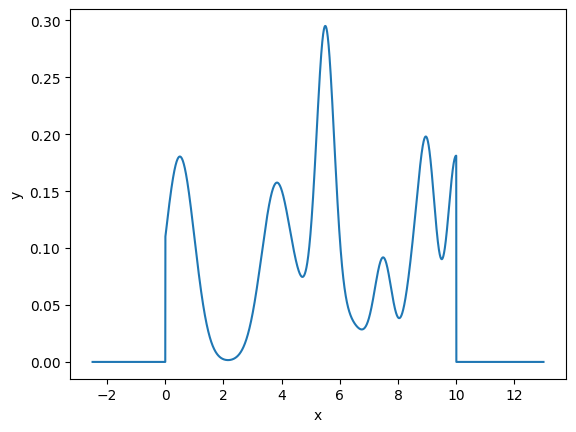

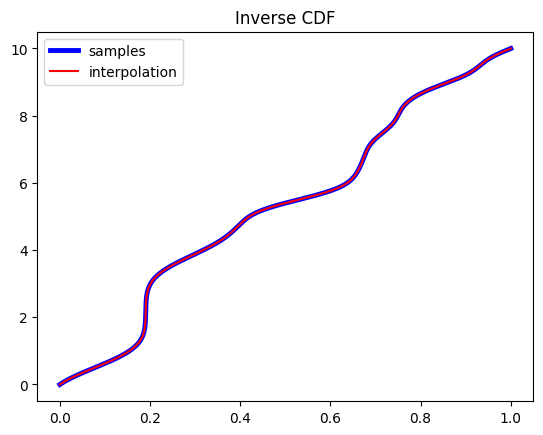

len(xs) = 50000. Sample time = 3.837252140045166
[4.88655997 5.86000607 3.99991221 ... 5.59524193 2.72267515 1.85955127]
[0.08821613957319369, 0.16789869814069192, 0.15086293366228046, 0.23936071210831097, 0.1793349077523191, 0.07257035514809898, 0.13080615851855706, 0.24293222758933913, 0.16367236451459358, 0.1249546452415971, 0.0577590632340422, 0.2587602448708754, 0.059663313357353365, 0.1960696357145144, 0.15243975015984246, 0.12550823837277073, 0.29306314783577936, 0.25127129897591494, 0.03373844128037527, 0.2844100252069098, 0.0840307216151103, 0.17818129574729707, 0.13238293329501644, 0.0893765113461703, 0.1478335378162371, 0.11973737259759364, 0.1548030219325505, 0.056369188244316686, 0.14988858638154298, 0.07830416925848747, 0.1541077858361242, 0.10509350899042755, 0.15737530103815392, 0.05515943919967116, 0.1848703365943801, 0.04810662812499358, 0.14697513235150717, 0.08740959396569233, 0.17805860642307345, 0.16723524467398332, 0.22644568710765067, 0.19614911253928877, 0.1804

In [ ]:
# Test run for sampling from generic distributions
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5]
weights = [weight/sum(weights) for weight in weights]
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10]
sigmas = [.3,.5,.5,1,.3,.3,.3,.3]
p1 = truncated_gaussian_mix(weights,mus,sigmas)
plot_f(p1,min(mus)-3*max(sigmas),max(mus)+3*max(sigmas))
print("")

def sample_from_dist_test(pdf,low,high,samples):
  randoms_01 = np.random.random(size=samples)
  inverse_cdf = get_inverse_cdf_test(pdf,low,high)
  random_values = inverse_cdf(randoms_01)
  return random_values

def get_inverse_cdf_test(pdf,low,high):
  xs = np.arange(low,high+1e-7,(high-low)/1000)
  ys = [integrate.quad(pdf,low,x)[0] for x in xs]
  inverse_cdf = CubicSpline(ys,xs)
  xs2 = [.0001*i for i in range(10001)]
  plt.plot(ys,xs,'b',label="samples",linewidth=3.5)
  plt.plot(xs2,inverse_cdf(xs2),'r',label="interpolation")
  plt.title("Inverse CDF")
  plt.legend()
  plt.show()
  return inverse_cdf

t0 = time.time()
xs = sample_from_dist_test(p1,0,10,50000)
t1 = time.time()
print(f"len(xs) = {len(xs)}. Sample time = {t1-t0}")
print(xs)
print([p1(x) for x in xs])

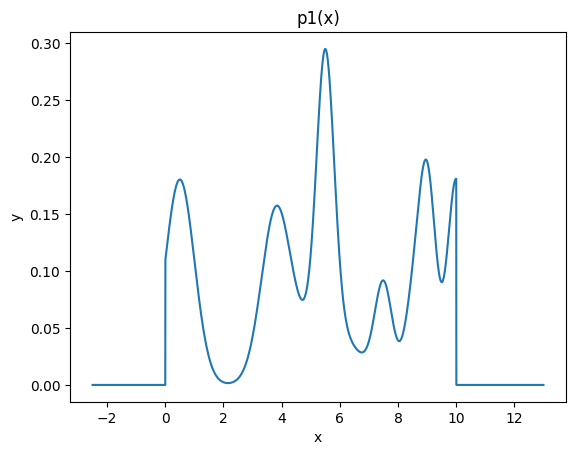

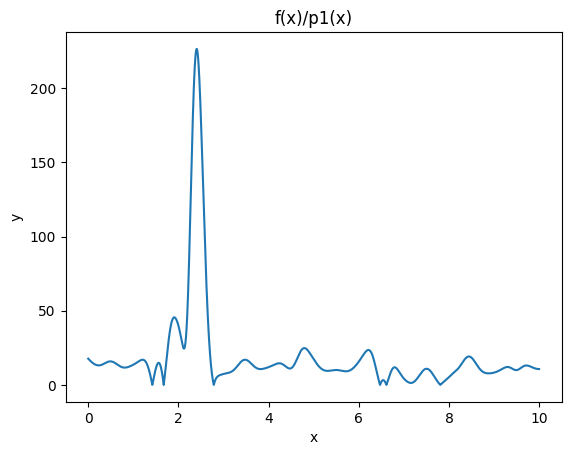

In [ ]:
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5]
weights = [weight/sum(weights) for weight in weights]
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10]
sigmas = [.3,.5,.5,1,.3,.3,.3,.3]
p1 = truncated_gaussian_mix(weights,mus,sigmas)
plot_f(p1,min(mus)-3*max(sigmas),max(mus)+3*max(sigmas),title="p1(x)")
print("")
g1 = lambda x: f(x)/p1(x)
plot_f(g1,0,10,title="f(x)/p1(x)")

In [ ]:
get_good_integral_estimate2(f,p1,a,b)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
samples = 524288, stdev = 0.010435382124426535
samples = 1048576, stdev = 0.007320458586912927
samples = 655360, stdev = 0.009462892616352116, low = 524288, high = 655360, (high-low)/low = 0.25
samples = 557056, stdev = 0.010598649962306115, low = 557057, high = 589824, (high-low)/low = 0.058821628666366275
samples = 581632, stdev = 0.009778622354847161, low = 573441, high = 581632, (high-low)/low = 0.01428394551488296
Number of samples: 577537
Integral estimate: 12.170677062043756
Variance of estimate: 9.804356818193454e-05
Standard deviation of estimate: 0.009901695217584439
Error of estimate: 0.001980934210696006
Time: 218.27667450904846


The large spike just above 2 suggests that the probability assigned to ~2.2 and the surrounding region is too low, and makes the variance of $\frac{f(x)}{p_1(x)}$ large. I'll try adding another gaussian to the mix to fix that.

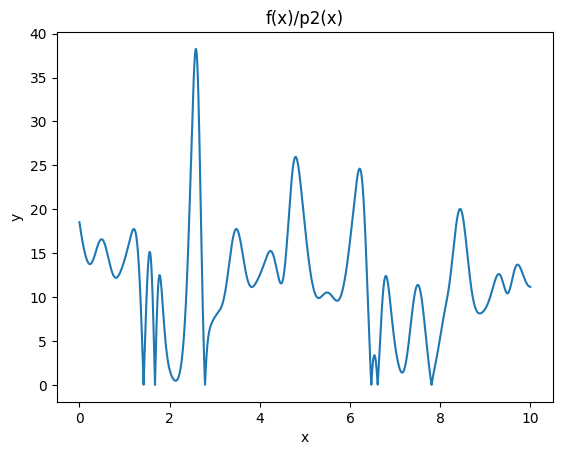

In [ ]:
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5,.5] # Made some adjustments to the estimate above
weights = [weight/sum(weights) for weight in weights]
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10,2.2]
sigmas = [.3,.5,.5,1,.3,.3,.3,.3,.2]
p2 = truncated_gaussian_mix(weights,mus,sigmas)
# plot_f(p1,min(mus)-3*max(sigmas),max(mus)+3*max(sigmas))

g2 = lambda x: f(x)/p2(x)
plot_f(g2,0,10,title="f(x)/p2(x)")

That looks better! The highest tick on the y axis (40) is much smaller than before (200). To recall the context, the lower variance of f(x)/p2(x) suggests that using p2 should allow for getting an accurate estimate of the integral of f(x) with fewer samples. Let's keep adding gaussians to the mixture wherever the largest outlier peaks are.

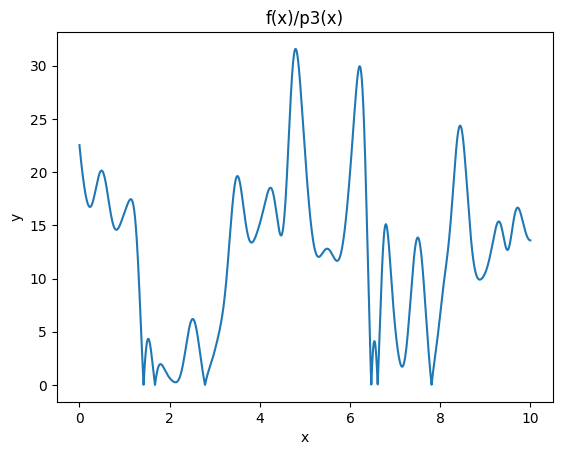

In [ ]:
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5,3]
weights = [weight/sum(weights) for weight in weights]
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10,2.3]
sigmas = [.3,.5,.5,1,.3,.3,.3,.3,.5]
p3 = truncated_gaussian_mix(weights,mus,sigmas)
# plot_f(p3,min(mus)-3*max(sigmas),max(mus)+3*max(sigmas))
# plot_f(f,0,10)

g3 = lambda x: f(x)/p3(x)
plot_f(g3,0,10,title="f(x)/p3(x)")

In [ ]:
get_good_integral_estimate2(f,p3,a,b)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
samples = 524288, stdev = 0.009387773890947604
samples = 491520, stdev = 0.009697042427538468, low = 458753, high = 491520, (high-low)/low = 0.07142623590472433
samples = 466944, stdev = 0.009935062440009829, low = 458753, high = 466944, (high-low)/low = 0.01785492410948811
Number of samples: 460800
Integral estimate: 12.177808477846673
Variance of estimate: 0.00010013346774988903
Standard deviation of estimate: 0.010006671162274147
Error of estimate: 0.009112350013612769
Time: 152.24559140205383


This actually required more samples. That's not shocking, because I'm just trying to reduce the variance by eyeballing it, and I can make mistakes. Let's try one more.

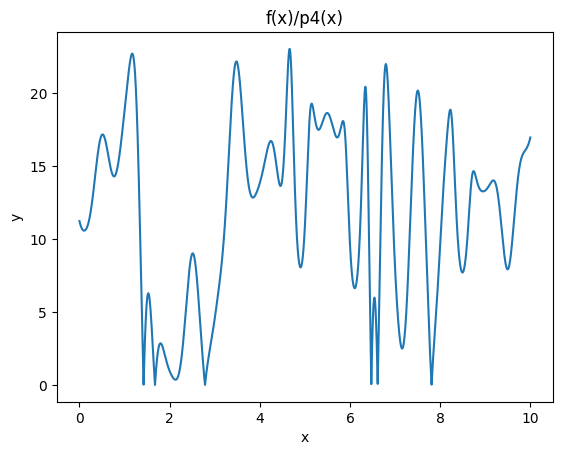

In [ ]:
weights = [2,2.5,2,1.5,.7,.5,1.5,1.5,3,1,1,1,1,1,1,1]
weights = [weight/sum(weights) for weight in weights]
mus = [5.5,.5,3.8,5.5,7.5,8.5,9,10,2.3,4.9,6.1,.5,4,8.5,0,9.5]
sigmas = [.3,.5,.5,1,.3,.3,.3,.3,.5,.1,.1,.3,.4,.1,.2,.3]
p4 = truncated_gaussian_mix(weights,mus,sigmas)
# plot_f(p3,min(mus)-3*max(sigmas),max(mus)+3*max(sigmas))
# plot_f(f,0,10)

g4 = lambda x: f(x)/p4(x)
plot_f(g4,0,10,title="f(x)/p4(x)")

In [ ]:
get_good_integral_estimate2(f,p4,a,b)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
samples = 2, stdev = 2.674584274972963
samples = 262144, stdev = 0.010477439765188798
samples = 524288, stdev = 0.007397397022320357
samples = 327680, stdev = 0.009334927161484622, low = 262144, high = 327680, (high-low)/low = 0.25
samples = 278528, stdev = 0.010132526552989407, low = 278529, high = 294912, (high-low)/low = 0.05881972792779208
samples = 290816, stdev = 0.0099296096959455, low = 286721, high = 290816, (high-low)/low = 0.014282176750220598
Number of samples: 286721
Integral estimate: 12.17618757670644
Variance of estimate: 9.967120674994619e-05
Standard deviation of estimate: 0.009983546802111271
Error of estimate: 0.0074914488733792695
Time: 237.42249584197998


This required fewer samples than p3, but still more than p2.

In [ ]:
low,high = 0,10
xs = np.arange(low,high+1e-7,(high-low)/1000)
ys = [0]
t0 = time.time()
prev_x = 0
for i in range(1,len(xs)):
  x = xs[i]
  new = integrate.quad(h1,prev_x,x)[0]
  ys.append(ys[-1]+new)
  prev_x = x
inverse_cdf = CubicSpline(ys,xs)

In [ ]:
true_value, max_error = integrate.quad(f,0,10,limit=int(1000))
opt_p = lambda x: f(x)/true_value
get_good_integral_estimate2(f,opt_p,a,b)

Integral true value: 12.16869612783306 (max error = 1.0543806361340557e-07)
Getting inverse cdf:


100%|██████████| 1000/1000 [00:00<00:00, 2122.11it/s]

Number of samples: 1
Integral estimate: 12.16869612783306
Variance of estimate: nan
Standard deviation of estimate: nan
Error of estimate: 0.0
Time: 0.4992520809173584



<ipython-input-19-8331709faa7b>:79: RuntimeWarning: invalid value encountered in double_scalars
  var = sum_of_squared_residuals/(samples*(samples-1))
<ipython-input-19-8331709faa7b>:90: RuntimeWarning: invalid value encountered in double_scalars
  var = sum_of_squared_residuals/(samples*(samples-1))


This makes sense as the optimal probability distribution. It isn't totally cheating - I didn't come up with opt_p = f(x)/true_value just because that means we are taking the expected value of f(x)/(f(x)/true_value)=true_value. Instead, I was aiming for a probability distribution that turns f(x)/p(x) into some constant, since that minimizes variance, and it is the case that in order for f(x) to cancel and p(x) to integrate to 1, p(x) has to be f(x)/true_value. This is in line with what we discussed in class, with the optimal probability distribution "following" the function whose integral we are trying to approximate.